# Imports et setup
## Imports des bibliothèques

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import timeit

from pandas.plotting import register_matplotlib_converters
from pandas.api.types import union_categoricals, CategoricalDtype

## Setup des outils de visualisation

In [2]:
%matplotlib inline
pd.set_option('display.max_columns', None)
register_matplotlib_converters()
sns.set(style="ticks", color_codes=True)

# Chargement du Dataset

## Définition des fichiers

In [3]:
# historiques de vente
file_list = ['./Data/LDV_CONV_1ALO_201707_201906_V3.csv',
             './Data/LDV_CONV_1ALO_V3_20190909.csv', 
             './Data/LDV_CONV_1ALO_V3_20190916.csv', 
             './Data/LDV_CONV_1ALO_V3_20191011.csv',
             './Data/LDV_CONV_1ALO_V3_20191024.csv']

client_filename = './Data/Référentiel_ConverteO_1ALO_Clt_20191024.csv'
material_filename = './Data/Référentiel_ConverteO_1ALO_Art_20191024.csv'
scope_filename = './Data/split_cli_test_reco.csv'

# Pour le moment, on n'intègre que le dernier fichier de reco
previous_reco_filename = './Data/Recos_KNN_post_filtres_20191024.csv'

## Historiques de vente

Définition du format, et de l'index cible (une fois la concaténation effectuée).

In [4]:
fields = {'orgacom':'category',
          'month':'category',
          'week':'category',
          'date':'object',
          'pricetype':'category',
          'client':'object',
          'doctype':'category',
          'origin':'category',
          'salesgroup':'category',
          'material':'object',
          'brutrevenue':'float',
          'brutrevcur':'category', 
          'netrevenue':'float', 
          'netrevcur':'category',
          'weight':'float',
          'weightunit':'category',
          'marginperkg':'float'}

Définition d'une fonction qui permet de concaténer les lignes d'historiques sur des fichiers transmis. Elle permet de concaténer des Dataframes (df1, df2, ..., dfN) dans l'ordre, avec la règle de gestion suivante : si une date est présente sur au moins une ligne du Dataframe df(n+1), toutes les lignes avec cette date sont supprimées du Dataframe df(n) avant concaténation.

C'est l'argument 'concat_index' qui va permettre d'identifier sur quelle donnée effectuer ces filtres successifs. Si 'concat_index' est passé avec 'date', alors si une date est présente dans un fichier alors qu'elle était dans un des fichiers précédents, alors elle est droppée (au profit du contenu du nouveau fichier).

De plus, les catégories sont alignées au fil de l'eau afin que la concaténation ne se traduisent pas par un upcast vers 'object'.

In [5]:
def concat_df(file_list, **kwargs):
    for file_path in file_list:
        if 'df' not in locals():
            print('Loading ' + file_path)
            df = pd.read_csv(file_path, **kwargs)
        else:
            print('Loading ' + file_path)
            df2 = pd.read_csv(file_path, **kwargs)
            for field, my_type in fields.items():
                if my_type == 'category':
                    uc = union_categoricals([df[field],df2[field]])
                    df[field] = pd.Categorical( df[field], categories=uc.categories )
                    df2[field] = pd.Categorical( df2[field], categories=uc.categories )
            df = pd.concat([df[~df.index.isin(df2.index)] ,df2])
    print('Done!')
    return(df)

Chargement des fichiers du dataset :

In [6]:
concat_index = ['date']

df = concat_df(file_list,
               sep=';', 
               header=None, 
               names=fields.keys(), 
               dtype=fields, 
               parse_dates=['date'], 
               index_col=concat_index)

Loading ./Data/LDV_CONV_1ALO_201707_201906_V3.csv
Loading ./Data/LDV_CONV_1ALO_V3_20190909.csv
Loading ./Data/LDV_CONV_1ALO_V3_20190916.csv
Loading ./Data/LDV_CONV_1ALO_V3_20191011.csv
Loading ./Data/LDV_CONV_1ALO_V3_20191024.csv
Done!


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2119814 entries, 2017-07-03 to 2019-10-23
Data columns (total 16 columns):
orgacom        category
month          category
week           category
pricetype      category
client         object
doctype        category
origin         category
salesgroup     category
material       object
brutrevenue    float64
brutrevcur     category
netrevenue     float64
netrevcur      category
weight         float64
weightunit     category
marginperkg    float64
dtypes: category(10), float64(4), object(2)
memory usage: 133.4+ MB


In [8]:
df.head()

,orgacom,month,week,pricetype,client,doctype,origin,salesgroup,material,brutrevenue,brutrevcur,netrevenue,netrevcur,weight,weightunit,marginperkg
date,,,,,,,,,,,,,,,,
2017-07-03,1ALO,201707,201727,ZTCE,0000022129,ZC10,VR,H19,000000000000002477,12.70,EUR,12.19,EUR,24.768,KG,0.07
2017-07-03,1ALO,201707,201727,ZTCE,0000022129,ZC10,VR,H19,000000000000008231,16.46,EUR,15.80,EUR,4.000,KG,0.49
2017-07-03,1ALO,201707,201727,ZTCE,0000022130,ZC10,TV,J88,000000000000034922,120.39,EUR,115.57,EUR,3.000,KG,3.71
2017-07-03,1ALO,201707,201727,ZTCE,0000022130,ZC10,TV,J88,000000000000004578,97.02,EUR,93.14,EUR,10.000,KG,1.42
2017-07-03,1ALO,201707,201727,ZTCE,0000080231,ZC10,VR,H21,000000000000018569,4.39,EUR,3.86,EUR,5.000,KG,0.14


On détruit l'index 'date', qui n'a que peu de sens.

In [9]:
df.reset_index(inplace=True)
df.head()

,date,orgacom,month,week,pricetype,client,doctype,origin,salesgroup,material,brutrevenue,brutrevcur,netrevenue,netrevcur,weight,weightunit,marginperkg
0,2017-07-03,1ALO,201707,201727,ZTCE,0000022129,ZC10,VR,H19,000000000000002477,12.70,EUR,12.19,EUR,24.768,KG,0.07
1,2017-07-03,1ALO,201707,201727,ZTCE,0000022129,ZC10,VR,H19,000000000000008231,16.46,EUR,15.80,EUR,4.000,KG,0.49
2,2017-07-03,1ALO,201707,201727,ZTCE,0000022130,ZC10,TV,J88,000000000000034922,120.39,EUR,115.57,EUR,3.000,KG,3.71
3,2017-07-03,1ALO,201707,201727,ZTCE,0000022130,ZC10,TV,J88,000000000000004578,97.02,EUR,93.14,EUR,10.000,KG,1.42
4,2017-07-03,1ALO,201707,201727,ZTCE,0000080231,ZC10,VR,H21,000000000000018569,4.39,EUR,3.86,EUR,5.000,KG,0.14


## Clients

### Chargement

On commence par charger le dataset.

In [10]:
fields = {'code client':'object',
          'libellé client':'object',
          'code catégorie client':'category',
          'libellé catéorie client':'category', 
          'KNA1-KATR5':'category',
          'KNA1-LOEVM':'category',
          'KNVV-LOEVM':'category',
          'KNVV-PLTYP':'category',
          'colonne_source_reco':'category',
          'GrVd':'category',
          'OrgCm':'category',
          'CDis':'category', 
          'Groupe':'category', 
          'P.':'category',
          'Cde postal':'category', 
          'KNA1-KATR1':'category', 
          'KNA1-KATR2':'category', 
          'KNA1-KATR3':'category', 
          'KNA1-KATR4':'category', 
          'KNA1-KATR6':'category'}

df_clt = pd.read_csv(client_filename, 
                     sep=';', 
                     header=0, 
                     encoding="ISO-8859-1", 
                     dtype=fields)
df_clt.head()

,code client,libellé client,code catégorie client,libellé catégorie client,KNA1-KATR5,KNA1-LOEVM,KNVV-LOEVM,KNVV-PLTYP,colonne_source_reco,GrVd,OrgCm,CDis,Groupe,P.,Cde postal,KNA1-KATR1,KNA1-KATR2,KNA1-KATR3,KNA1-KATR4,KNA1-KATR6
0,20584,CH SEDAN,ZM,Santé,ZM,NaN,X,T2,NaN,H23,1ALO,10,ZCLT,FR,08200,Z3,Z4,ZI,ZB,Z16
1,21798,MAISON D'ACCUEIL NAZARETH,ZN,3ème age,ZN,NaN,X,T2,NaN,H15,1ALO,10,ZCLT,FR,51210,Z3,Z4,ZI,ZD,Z19
2,21936,TRAITEUR LA MARMITTE D'EDDIE,ZY,Traiteur,ZY,NaN,NaN,T1,NaN,H21,1ALO,10,ZCLT,FR,02200,Z3,Z5,ZK,ZG,ZY
3,22572,EHPAD SAINT BENOIT,ZN,3ème age,ZN,NaN,NaN,T2,NaN,H23,1ALO,10,ZCHN,FR,08350,Z3,Z4,ZI,ZB,Z19
4,23499,EDPAMS JACQUES SOURDILLE,ZO,Etab. sociaux,ZO,NaN,NaN,T2,NaN,H23,1ALO,10,ZCRC,FR,08240,Z3,Z4,ZI,ZB,Z21


In [11]:
df_clt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15447 entries, 0 to 15446
Data columns (total 20 columns):
code client                 15447 non-null object
libellé client              15447 non-null object
code catégorie client       15447 non-null category
libellé catégorie client    15447 non-null object
KNA1-KATR5                  15447 non-null category
KNA1-LOEVM                  5272 non-null category
KNVV-LOEVM                  7106 non-null category
KNVV-PLTYP                  13005 non-null category
colonne_source_reco         0 non-null category
GrVd                        15397 non-null category
OrgCm                       15447 non-null category
CDis                        15447 non-null category
Groupe                      15447 non-null category
P.                          15447 non-null category
Cde postal                  15447 non-null category
KNA1-KATR1                  15447 non-null category
KNA1-KATR2                  15447 non-null category
KNA1-KATR3         

On ajoute les zéros au niveau du code client, pour pouvoir joindre avec la table des historiques de vente.

In [12]:
df_clt['code client'] = df_clt['code client'].apply(lambda x: x.zfill(10))

Ajout et tri de l'index

In [13]:
df_clt.set_index('code client', inplace=True)
df_clt.sort_index(inplace=True)

On contrôle qu'il n'y a pas de code client en double.

In [14]:
if np.any(df_clt.index.duplicated(keep=False)):
    raise RuntimeError('Attention ! Il existe des doublons sur l\'index du DataFrame df_clt')

In [15]:
df_clt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15447 entries, 0000010005 to PINTERIM52
Data columns (total 19 columns):
libellé client              15447 non-null object
code catégorie client       15447 non-null category
libellé catégorie client    15447 non-null object
KNA1-KATR5                  15447 non-null category
KNA1-LOEVM                  5272 non-null category
KNVV-LOEVM                  7106 non-null category
KNVV-PLTYP                  13005 non-null category
colonne_source_reco         0 non-null category
GrVd                        15397 non-null category
OrgCm                       15447 non-null category
CDis                        15447 non-null category
Groupe                      15447 non-null category
P.                          15447 non-null category
Cde postal                  15447 non-null category
KNA1-KATR1                  15447 non-null category
KNA1-KATR2                  15447 non-null category
KNA1-KATR3                  15447 non-null category
KNA1-KAT

### Analyse

On peut vérifier par exemple la répartition des clients pour chacun des différents niveaux de segmentation :

In [16]:
new_index = ['KNA1-KATR1', 'KNA1-KATR2', 'KNA1-KATR3', 'KNA1-KATR4', 'KNA1-KATR5', 'KNA1-KATR6', 'code client']
df_clt.reset_index().set_index(new_index).sort_index().head(15)

libellé client  \
KNA1-KATR1 KNA1-KATR2 KNA1-KATR3 KNA1-KATR4 KNA1-KATR5 KNA1-KATR6 code client                                        
Z1         Z1         ZA         ZW         Z8         Z40        0000020724                 RAYON TRAITEUR CHADIS   
                                                                  0000021753        LECLERC RAYON TRAITEUR CHAMBRY   
                                                                  0000022497     API CH GESTION CHAMPAGNE ARDENNES   
                                                                  0000022888                API P GESTION PICARDIE   
                                                                  0000023199   RAYON TRAITEUR LECLERC CHATEAU THIE   
                                                                  0000025579     RAYON TRAITEUR LECLERC CREUTZWALD   
                                                                  0000028105     RAYON BOUL PAT LECLERC VANDOEUVRE   
                                                                  0000028185   RAYON TRAITEUR CHARC LECLERC FAMECK   
                                                                  0000052022         RAYON BOUL PAT LECLERC FAMECK   
                                                                  0000118070        RAYON TRAITEUR LECLERC FROUARD   
                                                                  0000119083      RAYON ROTISSERIE LECLERC FROUARD   
                                                                  0000126886    RAYON VIENNOISERIE LECLERC FROUARD   
                                                                  0000191277             TRAIT TRAD LECLERC FAMECK   
                                                                  0000233901                       AUCHAN TRAITEUR   
                                 ZY         Z8         Z40        0000024242                 LECLERC CONTREXEVILLE   

                                                                              code catégorie client  \
KNA1-KATR1 KNA1-KATR2 KNA1-KATR3 KNA1-KATR4 KNA1-KATR5 KNA1-KATR6 code client                         
Z1         Z1         ZA         ZW         Z8         Z40        0000020724                     Z8   
                                                                  0000021753                     Z8   
                                                                  0000022497                     Z8   
                                                                  0000022888                     Z8   
                                                                  0000023199                     Z8   
                                                                  0000025579                     Z8   
                                                                  0000028105                     Z8   
                                                                  0000028185                     Z8   
                                                                  0000052022                     Z8   
                                                                  0000118070                     Z8   
                                                                  0000119083                     Z8   
                                                                  0000126886                     Z8   
                                                                  0000191277                     Z8   
                                                                  0000233901                     Z8   
                                 ZY         Z8         Z40        0000024242                     Z8   

                                                                              libellé catégorie client  \
KNA1-KATR1 KNA1-KATR2 KNA1-KATR3 KNA1-KATR4 KNA1-KATR5 KNA1-KATR6 code client                            
Z1         Z1         ZA         ZW         Z8         Z40        0000020724       Mag. Alim. Générale   
                       

Si on regarde uniquement la répartition des clients par segment, jusqu'à la restauration commerciale indépendante, et enfin en y filtrant les traiteurs (catégorie ZY) on obtient : 

In [17]:
segments = ['Z3', 'Z5', 'ZK', 'ZG']
filter = ['df_clt[\'KNA1-KATR' + str(i) + '\'] == \'' + segments[i-1] + '\', \'KNA1-KATR' + str(i+1) + '\'' for i in range(1, 5)]
filter

["df_clt['KNA1-KATR1'] == 'Z3', 'KNA1-KATR2'",
 "df_clt['KNA1-KATR2'] == 'Z5', 'KNA1-KATR3'",
 "df_clt['KNA1-KATR3'] == 'ZK', 'KNA1-KATR4'",
 "df_clt['KNA1-KATR4'] == 'ZG', 'KNA1-KATR5'"]

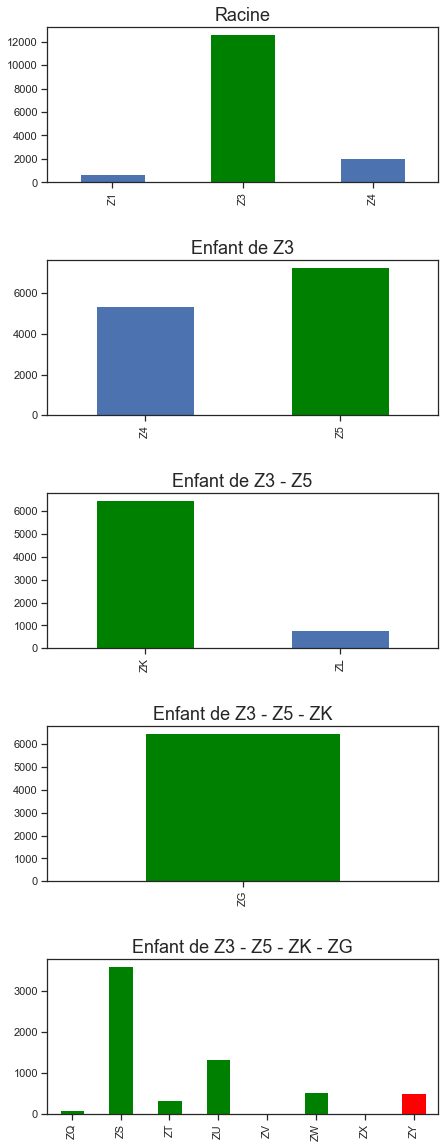

In [18]:
fig, axs = plt.subplots(5, 1, figsize=(7,20))
fig.subplots_adjust(hspace=0.5)

temp_df = df_clt.loc[:, 'KNA1-KATR1'].value_counts().sort_index()
colors = ['C0'] * len(temp_df.index)
colors[temp_df.index.get_loc(segments[0])] = 'green'
temp_df.plot(kind='bar', ax=axs[0], color=colors)
axs[0].set_title('Racine', fontsize=18)

for i in range(1, 5):
    temp_df = df_clt.loc[eval(filter[i-1])].value_counts().sort_index().loc[lambda x: x>0]
    colors = ['C0'] * len(temp_df.index)
    if i<4:
        colors[temp_df.index.get_loc(segments[i])] = 'green'
    else: 
        colors = ['green'] * len(temp_df.index)
        colors[temp_df.index.get_loc('ZY')] = 'red'
    temp_df.plot(kind='bar', ax=axs[i], color=colors)
    axs[i].set_title('Enfant de ' + ' - '.join(segments[:i]), fontsize=18)

## Articles

In [19]:
fields = {'code article':'object',
          'libellé article':'category',
          'code gamme':'category',
          'libellé gamme':'category', 
          'MARC-MMSTA':'category',
          'MARC-LVORM':'category',
          'MVKE-LVORM':'category',
          'MVKE-MVSTA':'category',
          'MARA-LVORM':'category',
          'Hiérarchie produit':'category',
          'Type d\'article':'category',
          'Division':'category', 
          'Org. commerciale':'category', 
          'Canal distribution':'category',
          'File d\'achat':'category', 
          'Marque industrielle':'category', 
          'Marque commerciale':'category', 
          'Grpe de marchandises':'category', 
          'Poids net':'float', 
          'Unité de p':'category',
          'V1':'category',
          'V2':'category',
          'V3':'category',
          'LG1':'category',
          'LG2':'category',         
         }

df_mat = pd.read_csv(material_filename, 
                     sep=';', 
                     header=0, 
                     encoding="ISO-8859-1", 
                     dtype=fields,
                     decimal=",")
df_mat.head()

,code article,libellé article,code gamme,libellé gamme,MARC-MMSTA,MARC-LVORM,MVKE-LVORM,MVKE-MVSTA,MARA-LVORM,Hiérarchie produit,Type d'article,Division,Org. commerciale,Canal distribution,File d'achat,Marque industrielle,Marque commerciale,Grpe de marchandises,Poids net,Unité de p,V1,V2,V3,LG1,LG2
0,84568,NPUMini cabecou 45% BIO (30Gx25),14,Gamme Fin de vie,ZD,X,X,Z0,X,101015152005,ZNEG,3E01,1ALO,10,FO,999,999,ZFRAIS,0.75,KG,A,A,A,FR,FR
1,84569,"NPUSt paulin BIO 50% (1,7KGx4)",14,Gamme Fin de vie,ZD,X,X,Z0,X,101015054075,ZNEG,3E01,1ALO,10,FO,999,999,ZFRAIS,1.00,KG,A,A,A,FR,FR
2,84572,NPU Appareil pour gratin (1Lx6) Debic,14,Gamme Fin de vie,ZD,X,X,Z0,X,203510050505,ZNEG,3E01,1ALO,10,UF,4,1,ZFRAIS,1.00,KG,A,A,A,FR,FR
3,84585,"NPUEpaule lamelle ct BIO s/v (2,5KGx2)",14,Gamme Fin de vie,ZD,X,X,Z0,X,400530051505,ZNEG,3E01,1ALO,10,POR,999,999,ZFRAIS,1.00,KG,A,A,A,FR,FR
4,84586,NPUMortadelle pur porc BIO (3KGx2) /6KG,14,Gamme Fin de vie,ZD,X,X,Z0,X,400510051005,ZNEG,3E01,1ALO,10,POR,999,999,ZFRAIS,1.00,KG,A,A,A,FR,FR


In [20]:
df_mat['code article'] = df_mat['code article'].apply(lambda x: x.zfill(18))

In [21]:
df_mat.set_index('code article', inplace=True)

In [22]:
df_mat.head()

,libellé article,code gamme,libellé gamme,MARC-MMSTA,MARC-LVORM,MVKE-LVORM,MVKE-MVSTA,MARA-LVORM,Hiérarchie produit,Type d'article,Division,Org. commerciale,Canal distribution,File d'achat,Marque industrielle,Marque commerciale,Grpe de marchandises,Poids net,Unité de p,V1,V2,V3,LG1,LG2
code article,,,,,,,,,,,,,,,,,,,,,,,,
000000000000084568,NPUMini cabecou 45% BIO (30Gx25),14,Gamme Fin de vie,ZD,X,X,Z0,X,101015152005,ZNEG,3E01,1ALO,10,FO,999,999,ZFRAIS,0.75,KG,A,A,A,FR,FR
000000000000084569,"NPUSt paulin BIO 50% (1,7KGx4)",14,Gamme Fin de vie,ZD,X,X,Z0,X,101015054075,ZNEG,3E01,1ALO,10,FO,999,999,ZFRAIS,1.00,KG,A,A,A,FR,FR
000000000000084572,NPU Appareil pour gratin (1Lx6) Debic,14,Gamme Fin de vie,ZD,X,X,Z0,X,203510050505,ZNEG,3E01,1ALO,10,UF,4,1,ZFRAIS,1.00,KG,A,A,A,FR,FR
000000000000084585,"NPUEpaule lamelle ct BIO s/v (2,5KGx2)",14,Gamme Fin de vie,ZD,X,X,Z0,X,400530051505,ZNEG,3E01,1ALO,10,POR,999,999,ZFRAIS,1.00,KG,A,A,A,FR,FR
000000000000084586,NPUMortadelle pur porc BIO (3KGx2) /6KG,14,Gamme Fin de vie,ZD,X,X,Z0,X,400510051005,ZNEG,3E01,1ALO,10,POR,999,999,ZFRAIS,1.00,KG,A,A,A,FR,FR


## Périmètre client

On récupère le périmètre client, et on ajoute cette info au dataset client.

In [23]:
fields = {'code article':'object',
          'GrVd':'category',
          'code_client':'object', 
          'marge_livraison_moy_cli':'float',
          'rank_MLV_intra_GV':'int64', 
          'flag_reco':'int64',
          'groupe_test':'category'
         }

df_perim_clt = pd.read_csv(scope_filename, 
                           sep=';', 
                           header=0, 
                           dtype=fields)
df_perim_clt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1684 entries, 0 to 1683
Data columns (total 6 columns):
GrVd                       1684 non-null category
code_client                1684 non-null object
marge_livraison_moy_cli    1684 non-null float64
rank_MLV_intra_GV          1684 non-null int64
flag_reco                  1684 non-null int64
groupe_test                1684 non-null category
dtypes: category(2), float64(1), int64(2), object(1)
memory usage: 57.7+ KB


In [24]:
df_clt.head()

,libellé client,code catégorie client,libellé catégorie client,KNA1-KATR5,KNA1-LOEVM,KNVV-LOEVM,KNVV-PLTYP,colonne_source_reco,GrVd,OrgCm,CDis,Groupe,P.,Cde postal,KNA1-KATR1,KNA1-KATR2,KNA1-KATR3,KNA1-KATR4,KNA1-KATR6
code client,,,,,,,,,,,,,,,,,,,
0000010005,INTERGROS,Z5,Pers.Gpe/Collectivit,Z5,NaN,NaN,NaN,NaN,585,1ALO,10,ZCLT,FR,93192,Z4,Z0,ZQ,ZO,Z27
0000010007,LOGISTIQUE VIANDE DE L'EST,Z3,Groupe,Z3,X,X,T1,NaN,585,1ALO,10,ZCLT,FR,54710,Z4,Z9,ZO,ZM,Z26
0000010087,ERHARD VIENNOISERIE TRAITEUR,ZK,Magasin Spécialisé,ZK,NaN,X,T1,NaN,M98,1ALO,10,ZCLT,FR,25870,Z1,Z3,ZH,ZX,Z07
0000011497,CRS 52 SANCERRE,ZR,Sécurité,ZR,NaN,NaN,T1,NaN,H21,1ALO,10,ZCLT,FR,18300,Z3,Z4,ZI,ZB,ZI
0000013739,CELLULE APPRO MEDICA,ZM,Santé,ZM,NaN,NaN,NaN,NaN,588,1ALO,10,ZCHN,FR,13196,Z3,Z4,ZJ,ZF,Z17


In [25]:
df_perim_clt['code_client'] = df_perim_clt['code_client'].str.zfill(10)
df_perim_clt.set_index('code_client', inplace=True)
df_perim_clt.head()

,GrVd,marge_livraison_moy_cli,rank_MLV_intra_GV,flag_reco,groupe_test
code_client,,,,,
0000165975,M98,664.147545,1,1,Reco_Converteo
0000245052,M98,195.362850,2,0,No_reco
0000104013,M98,178.712512,3,1,Reco_Converteo
0000026267,M98,152.073390,4,0,No_reco
0000194379,M98,125.366884,5,1,Reco_Converteo


In [26]:
df_perim_clt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1684 entries, 0000165975 to 0000178819
Data columns (total 5 columns):
GrVd                       1684 non-null category
marge_livraison_moy_cli    1684 non-null float64
rank_MLV_intra_GV          1684 non-null int64
flag_reco                  1684 non-null int64
groupe_test                1684 non-null category
dtypes: category(2), float64(1), int64(2)
memory usage: 57.6+ KB


In [27]:
df_clt['flag_reco'] = 0
df_clt.update(df_perim_clt['flag_reco'])
df_clt['flag_reco'] = df_clt['flag_reco'].astype(np.int64)
df_clt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15447 entries, 0000010005 to PINTERIM52
Data columns (total 20 columns):
libellé client              15447 non-null object
code catégorie client       15447 non-null category
libellé catégorie client    15447 non-null object
KNA1-KATR5                  15447 non-null category
KNA1-LOEVM                  5272 non-null category
KNVV-LOEVM                  7106 non-null category
KNVV-PLTYP                  13005 non-null category
colonne_source_reco         0 non-null category
GrVd                        15397 non-null category
OrgCm                       15447 non-null category
CDis                        15447 non-null category
Groupe                      15447 non-null category
P.                          15447 non-null category
Cde postal                  15447 non-null category
KNA1-KATR1                  15447 non-null category
KNA1-KATR2                  15447 non-null category
KNA1-KATR3                  15447 non-null category
KNA1-KAT

In [28]:
df_clt.groupby('flag_reco').size()

flag_reco
0    14594
1      853
dtype: int64

In [29]:
del df_perim_clt

## Recommandations précédentes

On commence par charger le fichier.

In [30]:
fields = {'Code_client':'object',
          'Code_article':'object',
          'xcom':'category',
          'xdelais':'category',
          'mailDemandeur':'category',
          'libelleClient':'object',
          'libelleArticle':'object',
          'origine':'category',
          'rang':'int64',
          'rating':'float64'
         }

df_prev_reco = pd.read_csv(previous_reco_filename, 
                          sep=';', 
                          header=0, 
                          dtype=fields,
                          encoding="ISO-8859-1")

df_prev_reco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2559 entries, 0 to 2558
Data columns (total 10 columns):
Code_client       2559 non-null object
Code_article      2559 non-null object
xcom              2559 non-null category
xdelais           2559 non-null category
mailDemandeur     2559 non-null category
libelleClient     2559 non-null object
libelleArticle    2559 non-null object
origine           2559 non-null category
rang              2559 non-null int64
rating            2559 non-null float64
dtypes: category(4), float64(1), int64(1), object(4)
memory usage: 130.1+ KB


On met à jour le code article (zéro fillé sur 18 digits).

On récupère certains champs du dataframe article (pour le moment, la hiérarchie produit).

In [31]:
df_prev_reco['Code_article'] = df_prev_reco['Code_article'].apply(lambda x: x.zfill(18))
df_prev_reco = df_prev_reco.set_index('Code_article').join(df_mat['Hiérarchie produit']).reset_index()
df_prev_reco.rename(columns={'index':'Code_article'}, inplace=True)
df_prev_reco.head()

,Code_article,Code_client,xcom,xdelais,mailDemandeur,libelleClient,libelleArticle,origine,rang,rating,Hiérarchie produit
0,000000000000000246,0000053891,Proposition algorithme,09/11/2019,DSI-Etudes-Data-Converteo@groupe-pomona.fr,REST LA CUILLER A POT,Marron 1KGx10 /10KG,algo,3,11.890,301010051005
1,000000000000000246,0000028499,Proposition algorithme,09/11/2019,DSI-Etudes-Data-Converteo@groupe-pomona.fr,HOTEL LES BUTTES,Marron 1KGx10 /10KG,algo,2,5.507,301010051005
2,000000000000000303,0000025568,Proposition algorithme,09/11/2019,DSI-Etudes-Data-Converteo@groupe-pomona.fr,RESTAURANT LE PETIT CUNY,Spatzle oeuf 1KGx3 /3KG,algo,3,3.382,203515100505
3,000000000000000389,0000142904,Proposition algorithme,09/11/2019,DSI-Etudes-Data-Converteo@groupe-pomona.fr,BRASSERIE SAINT PIERRE,"Frite 9/9 (2,5KGx5) /12,5KG McCain",algo,1,15.877,300505500505
4,000000000000000422,0000020936,Proposition algorithme,09/11/2019,DSI-Etudes-Data-Converteo@groupe-pomona.fr,RESTAURANT HOTEL DES VOYAGEURS,"Noix entrecote bf AMS 1,5/2KG",algo,2,2.611,401015201030


## Merges

In [32]:
df = df.merge(df_clt, how='left', left_on=['client'], right_index=True, validate='m:1')
df = df.merge(df_mat, how='left', left_on='material', right_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2119814 entries, 0 to 2119813
Data columns (total 61 columns):
date                        datetime64[ns]
orgacom                     category
month                       category
week                        category
pricetype                   category
client                      object
doctype                     category
origin                      category
salesgroup                  category
material                    object
brutrevenue                 float64
brutrevcur                  category
netrevenue                  float64
netrevcur                   category
weight                      float64
weightunit                  category
marginperkg                 float64
libellé client              object
code catégorie client       category
libellé catégorie client    object
KNA1-KATR5                  category
KNA1-LOEVM                  category
KNVV-LOEVM                  category
KNVV-PLTYP                  category
colon

In [33]:
df.head()

,date,orgacom,month,week,pricetype,client,doctype,origin,salesgroup,material,brutrevenue,brutrevcur,netrevenue,netrevcur,weight,weightunit,marginperkg,libellé client,code catégorie client,libellé catégorie client,KNA1-KATR5,KNA1-LOEVM,KNVV-LOEVM,KNVV-PLTYP,colonne_source_reco,GrVd,OrgCm,CDis,Groupe,P.,Cde postal,KNA1-KATR1,KNA1-KATR2,KNA1-KATR3,KNA1-KATR4,KNA1-KATR6,flag_reco,libellé article,code gamme,libellé gamme,MARC-MMSTA,MARC-LVORM,MVKE-LVORM,MVKE-MVSTA,MARA-LVORM,Hiérarchie produit,Type d'article,Division,Org. commerciale,Canal distribution,File d'achat,Marque industrielle,Marque commerciale,Grpe de marchandises,Poids net,Unité de p,V1,V2,V3,LG1,LG2
0,2017-07-03,1ALO,201707,201727,ZTCE,0000022129,ZC10,VR,H19,000000000000002477,12.70,EUR,12.19,EUR,24.768,KG,0.07,COMPTOIR DE LA LICORNE CHALONS,ZS,Rest. traditionnelle,ZS,NaN,NaN,T1,NaN,H19,1ALO,10,ZCLT,FR,51000,Z3,Z5,ZK,ZG,ZK,0,Lait 1/2 ecreme UHT France (1Lx6brq),4,Gamme Tronc Assortim,NaN,NaN,NaN,NaN,NaN,101020151010,ZNEG,3E01,1ALO,10,UF,999,999,ZFRAIS,1.032,KG,A,A,A,FR,FR
1,2017-07-03,1ALO,201707,201727,ZTCE,0000022129,ZC10,VR,H19,000000000000008231,16.46,EUR,15.80,EUR,4.000,KG,0.49,COMPTOIR DE LA LICORNE CHALONS,ZS,Rest. traditionnelle,ZS,NaN,NaN,T1,NaN,H19,1ALO,10,ZCLT,FR,51000,Z3,Z5,ZK,ZG,ZK,0,Emmental rape 29% 1KGx10 PPF,4,Gamme Tronc Assortim,NaN,NaN,NaN,NaN,NaN,101015102015,ZNEG,3E01,1ALO,10,FO,11,4,ZFRAIS,1.000,KG,A,A,A,FR,FR
2,2017-07-03,1ALO,201707,201727,ZTCE,0000022130,ZC10,TV,J88,000000000000034922,120.39,EUR,115.57,EUR,3.000,KG,3.71,COMPTOIR DE MAITRE KANTER BAR LE DU,ZS,Rest. traditionnelle,ZS,NaN,NaN,T1,NaN,J88,1ALO,10,ZCLT,FR,55000,Z3,Z5,ZK,ZG,ZK,0,FG canard cru eveine plaque 500Gx6,4,Gamme Tronc Assortim,NaN,NaN,NaN,NaN,NaN,401530150505,ZNEG,3E01,1ALO,10,VOL,124,17,ZSURGE,0.500,KG,A,A,A,FR,FR
3,2017-07-03,1ALO,201707,201727,ZTCE,0000022130,ZC10,TV,J88,000000000000004578,97.02,EUR,93.14,EUR,10.000,KG,1.42,COMPTOIR DE MAITRE KANTER BAR LE DU,ZS,Rest. traditionnelle,ZS,NaN,NaN,T1,NaN,J88,1ALO,10,ZCLT,FR,55000,Z3,Z5,ZK,ZG,ZK,0,Crevette ent cru sauv 10/20Pce/KG 2KGx6,4,Gamme Tronc Assortim,NaN,NaN,NaN,NaN,NaN,500505100510,ZNEG,3E01,1ALO,10,CRUST MOL,999,999,ZSURGE,2.000,KG,A,A,A,FR,FR
4,2017-07-03,1ALO,201707,201727,ZTCE,0000080231,ZC10,VR,H21,000000000000018569,4.39,EUR,3.86,EUR,5.000,KG,0.14,LES DELICES D ANDRE,ZY,Traiteur,ZY,NaN,NaN,T1,NaN,I56,1ALO,10,ZCLT,FR,51390,Z3,Z5,ZK,ZG,ZY,0,"Legume ratatouille 2,5KGx4 /10KG PPF",4,Gamme Tronc Assortim,NaN,NaN,NaN,NaN,NaN,301520050505,ZNEG,3E01,1ALO,10,LEG,11,4,ZSURGE,2.500,KG,A,A,A,FR,FR


## Filtre sur les types de documents à conserver

On ne conserve que les lignes qui concernent des commandes de vente.

In [34]:
filtered_doctypes = ['ZC01', 'ZC02', 'ZC10']
df = df[df.doctype.isin(filtered_doctypes)].copy()
cat_type = CategoricalDtype(categories=['ZC10', 'ZC01', 'ZC02'], ordered=True)
df['doctype'] = df['doctype'].astype(cat_type)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2100947 entries, 0 to 2119813
Data columns (total 61 columns):
date                        datetime64[ns]
orgacom                     category
month                       category
week                        category
pricetype                   category
client                      object
doctype                     category
origin                      category
salesgroup                  category
material                    object
brutrevenue                 float64
brutrevcur                  category
netrevenue                  float64
netrevcur                   category
weight                      float64
weightunit                  category
marginperkg                 float64
libellé client              object
code catégorie client       category
libellé catégorie client    object
KNA1-KATR5                  category
KNA1-LOEVM                  category
KNVV-LOEVM                  category
KNVV-PLTYP                  category
colon

In [36]:
df.head()

,date,orgacom,month,week,pricetype,client,doctype,origin,salesgroup,material,brutrevenue,brutrevcur,netrevenue,netrevcur,weight,weightunit,marginperkg,libellé client,code catégorie client,libellé catégorie client,KNA1-KATR5,KNA1-LOEVM,KNVV-LOEVM,KNVV-PLTYP,colonne_source_reco,GrVd,OrgCm,CDis,Groupe,P.,Cde postal,KNA1-KATR1,KNA1-KATR2,KNA1-KATR3,KNA1-KATR4,KNA1-KATR6,flag_reco,libellé article,code gamme,libellé gamme,MARC-MMSTA,MARC-LVORM,MVKE-LVORM,MVKE-MVSTA,MARA-LVORM,Hiérarchie produit,Type d'article,Division,Org. commerciale,Canal distribution,File d'achat,Marque industrielle,Marque commerciale,Grpe de marchandises,Poids net,Unité de p,V1,V2,V3,LG1,LG2
0,2017-07-03,1ALO,201707,201727,ZTCE,0000022129,ZC10,VR,H19,000000000000002477,12.70,EUR,12.19,EUR,24.768,KG,0.07,COMPTOIR DE LA LICORNE CHALONS,ZS,Rest. traditionnelle,ZS,NaN,NaN,T1,NaN,H19,1ALO,10,ZCLT,FR,51000,Z3,Z5,ZK,ZG,ZK,0,Lait 1/2 ecreme UHT France (1Lx6brq),4,Gamme Tronc Assortim,NaN,NaN,NaN,NaN,NaN,101020151010,ZNEG,3E01,1ALO,10,UF,999,999,ZFRAIS,1.032,KG,A,A,A,FR,FR
1,2017-07-03,1ALO,201707,201727,ZTCE,0000022129,ZC10,VR,H19,000000000000008231,16.46,EUR,15.80,EUR,4.000,KG,0.49,COMPTOIR DE LA LICORNE CHALONS,ZS,Rest. traditionnelle,ZS,NaN,NaN,T1,NaN,H19,1ALO,10,ZCLT,FR,51000,Z3,Z5,ZK,ZG,ZK,0,Emmental rape 29% 1KGx10 PPF,4,Gamme Tronc Assortim,NaN,NaN,NaN,NaN,NaN,101015102015,ZNEG,3E01,1ALO,10,FO,11,4,ZFRAIS,1.000,KG,A,A,A,FR,FR
2,2017-07-03,1ALO,201707,201727,ZTCE,0000022130,ZC10,TV,J88,000000000000034922,120.39,EUR,115.57,EUR,3.000,KG,3.71,COMPTOIR DE MAITRE KANTER BAR LE DU,ZS,Rest. traditionnelle,ZS,NaN,NaN,T1,NaN,J88,1ALO,10,ZCLT,FR,55000,Z3,Z5,ZK,ZG,ZK,0,FG canard cru eveine plaque 500Gx6,4,Gamme Tronc Assortim,NaN,NaN,NaN,NaN,NaN,401530150505,ZNEG,3E01,1ALO,10,VOL,124,17,ZSURGE,0.500,KG,A,A,A,FR,FR
3,2017-07-03,1ALO,201707,201727,ZTCE,0000022130,ZC10,TV,J88,000000000000004578,97.02,EUR,93.14,EUR,10.000,KG,1.42,COMPTOIR DE MAITRE KANTER BAR LE DU,ZS,Rest. traditionnelle,ZS,NaN,NaN,T1,NaN,J88,1ALO,10,ZCLT,FR,55000,Z3,Z5,ZK,ZG,ZK,0,Crevette ent cru sauv 10/20Pce/KG 2KGx6,4,Gamme Tronc Assortim,NaN,NaN,NaN,NaN,NaN,500505100510,ZNEG,3E01,1ALO,10,CRUST MOL,999,999,ZSURGE,2.000,KG,A,A,A,FR,FR
4,2017-07-03,1ALO,201707,201727,ZTCE,0000080231,ZC10,VR,H21,000000000000018569,4.39,EUR,3.86,EUR,5.000,KG,0.14,LES DELICES D ANDRE,ZY,Traiteur,ZY,NaN,NaN,T1,NaN,I56,1ALO,10,ZCLT,FR,51390,Z3,Z5,ZK,ZG,ZY,0,"Legume ratatouille 2,5KGx4 /10KG PPF",4,Gamme Tronc Assortim,NaN,NaN,NaN,NaN,NaN,301520050505,ZNEG,3E01,1ALO,10,LEG,11,4,ZSURGE,2.500,KG,A,A,A,FR,FR


In [37]:
df.groupby(by='doctype').size()

doctype
ZC10    2098631
ZC01         30
ZC02       2286
dtype: int64

In [38]:
del df_clt
del df_mat

## Filtre sur les lignes de traiteurs

On retire les lignes de traiteur

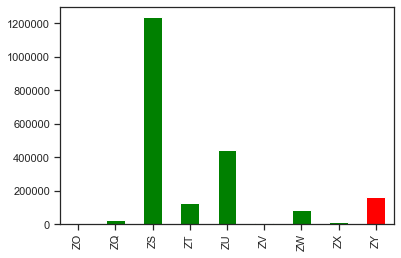

In [39]:
color = ['green'] * 9
color[8] = 'red'
df.loc[:, 'KNA1-KATR5'].value_counts().sort_index().loc[lambda x: x>0].plot(kind='bar', color=color)

Remarque : cette fois, on n'est plus sur un nombre de clients, mais sur un nombre de lignes dans le dataset d'historiques de vente.

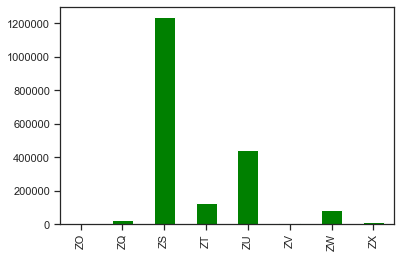

In [40]:
df.drop(df[df['KNA1-KATR5'] == 'ZY'].index, inplace=True)
df.loc[:, 'KNA1-KATR5'].value_counts().sort_index().loc[lambda x: x>0].plot(kind='bar', color=color)

Les lignes du dataset concernant les traiteurs on disparu.

## Analyse des premiers ratios

In [41]:
df.describe()

,brutrevenue,netrevenue,weight,marginperkg,flag_reco,Poids net
count,1.936800e+06,1.936800e+06,1.936800e+06,1.936800e+06,1.936800e+06,1.936797e+06
mean,3.462850e+01,3.431540e+01,6.401303e+00,2.438733e+00,4.713429e-01,1.530645e+00
std,1.076679e+02,1.073645e+02,1.292221e+01,6.644159e+00,4.991782e-01,1.533480e+00
min,0.000000e+00,-2.660200e+03,0.000000e+00,-3.174800e+02,0.000000e+00,2.000000e-02
25%,1.130000e+01,1.120000e+01,1.625000e+00,1.060000e+00,0.000000e+00,1.000000e+00
50%,2.050000e+01,2.027000e+01,3.422000e+00,2.010000e+00,0.000000e+00,1.000000e+00
75%,3.990000e+01,3.960000e+01,6.192000e+00,3.290000e+00,1.000000e+00,1.625000e+00
max,1.276500e+05,1.276500e+05,2.880000e+03,8.188860e+03,1.000000e+00,5.800000e+01


On voit que certains ratios sont nuls (CA et poids), ce qui risque de poser problème lors du calcul de nouveaux indicateurs (ex : prix de vente au kg, marge %, ...)

On va commencer par analyser les incohérences potentielles, en identifiant les relations pour lesquelles les ratios nuls sont incohérents entre eux.

On abandonne la notion de CA net net, qui est une donnée purement "gestion" et pas commerciale.

In [42]:
cat_type = pd.api.types.CategoricalDtype(categories=['neg', 'nul', 'pos'],
                            ordered=True)

df['rev_cat'] = 'pos'
df.loc[df['brutrevenue'] == 0, 'rev_cat'] = 'nul'
df['rev_cat'] = df['rev_cat'].astype(cat_type)
df['wei_cat'] = 'pos'
df.loc[df['weight'] == 0, 'wei_cat'] = 'nul'
df['wei_cat'] = df['wei_cat'].astype(cat_type)
df['mrg_cat'] = 'pos'
df.loc[df['marginperkg'] == 0, 'mrg_cat'] = 'nul'
df.loc[df['marginperkg'] < 0, 'mrg_cat'] = 'neg'
df['mrg_cat'] = df['mrg_cat'].astype(cat_type)
df.head()

,date,orgacom,month,week,pricetype,client,doctype,origin,salesgroup,material,brutrevenue,brutrevcur,netrevenue,netrevcur,weight,weightunit,marginperkg,libellé client,code catégorie client,libellé catégorie client,KNA1-KATR5,KNA1-LOEVM,KNVV-LOEVM,KNVV-PLTYP,colonne_source_reco,GrVd,OrgCm,CDis,Groupe,P.,Cde postal,KNA1-KATR1,KNA1-KATR2,KNA1-KATR3,KNA1-KATR4,KNA1-KATR6,flag_reco,libellé article,code gamme,libellé gamme,MARC-MMSTA,MARC-LVORM,MVKE-LVORM,MVKE-MVSTA,MARA-LVORM,Hiérarchie produit,Type d'article,Division,Org. commerciale,Canal distribution,File d'achat,Marque industrielle,Marque commerciale,Grpe de marchandises,Poids net,Unité de p,V1,V2,V3,LG1,LG2,rev_cat,wei_cat,mrg_cat
0,2017-07-03,1ALO,201707,201727,ZTCE,0000022129,ZC10,VR,H19,000000000000002477,12.70,EUR,12.19,EUR,24.768,KG,0.07,COMPTOIR DE LA LICORNE CHALONS,ZS,Rest. traditionnelle,ZS,NaN,NaN,T1,NaN,H19,1ALO,10,ZCLT,FR,51000,Z3,Z5,ZK,ZG,ZK,0,Lait 1/2 ecreme UHT France (1Lx6brq),4,Gamme Tronc Assortim,NaN,NaN,NaN,NaN,NaN,101020151010,ZNEG,3E01,1ALO,10,UF,999,999,ZFRAIS,1.032,KG,A,A,A,FR,FR,pos,pos,pos
1,2017-07-03,1ALO,201707,201727,ZTCE,0000022129,ZC10,VR,H19,000000000000008231,16.46,EUR,15.80,EUR,4.000,KG,0.49,COMPTOIR DE LA LICORNE CHALONS,ZS,Rest. traditionnelle,ZS,NaN,NaN,T1,NaN,H19,1ALO,10,ZCLT,FR,51000,Z3,Z5,ZK,ZG,ZK,0,Emmental rape 29% 1KGx10 PPF,4,Gamme Tronc Assortim,NaN,NaN,NaN,NaN,NaN,101015102015,ZNEG,3E01,1ALO,10,FO,11,4,ZFRAIS,1.000,KG,A,A,A,FR,FR,pos,pos,pos
2,2017-07-03,1ALO,201707,201727,ZTCE,0000022130,ZC10,TV,J88,000000000000034922,120.39,EUR,115.57,EUR,3.000,KG,3.71,COMPTOIR DE MAITRE KANTER BAR LE DU,ZS,Rest. traditionnelle,ZS,NaN,NaN,T1,NaN,J88,1ALO,10,ZCLT,FR,55000,Z3,Z5,ZK,ZG,ZK,0,FG canard cru eveine plaque 500Gx6,4,Gamme Tronc Assortim,NaN,NaN,NaN,NaN,NaN,401530150505,ZNEG,3E01,1ALO,10,VOL,124,17,ZSURGE,0.500,KG,A,A,A,FR,FR,pos,pos,pos
3,2017-07-03,1ALO,201707,201727,ZTCE,0000022130,ZC10,TV,J88,000000000000004578,97.02,EUR,93.14,EUR,10.000,KG,1.42,COMPTOIR DE MAITRE KANTER BAR LE DU,ZS,Rest. traditionnelle,ZS,NaN,NaN,T1,NaN,J88,1ALO,10,ZCLT,FR,55000,Z3,Z5,ZK,ZG,ZK,0,Crevette ent cru sauv 10/20Pce/KG 2KGx6,4,Gamme Tronc Assortim,NaN,NaN,NaN,NaN,NaN,500505100510,ZNEG,3E01,1ALO,10,CRUST MOL,999,999,ZSURGE,2.000,KG,A,A,A,FR,FR,pos,pos,pos
7,2017-07-03,1ALO,201707,201727,ZTCN,0000093753,ZC10,VR,I85,000000000000013148,12.82,EUR,11.92,EUR,6.000,KG,0.32,HOTEL MODERNE CAHEN ET CIE,ZT,Rest. hôtelière,ZT,NaN,NaN,T1,NaN,I85,1ALO,10,ZCLT,FR,57000,Z3,Z5,ZK,ZG,ZM,0,Yt Danone et Fruit panaché (125Gx8)x6,6,Gamme Imposée Grands,NaN,NaN,NaN,NaN,NaN,101025351010,ZNEG,3E01,1ALO,10,UF,28,62,ZFRAIS,1.000,KG,A,A,A,FR,FR,pos,pos,pos


In [43]:
df.groupby(by=['rev_cat', 'wei_cat', 'mrg_cat'])['material'].count().unstack()

mrg_cat             neg      nul        pos
rev_cat wei_cat                            
nul     nul         NaN  11785.0        NaN
        pos      3952.0      1.0        7.0
pos     nul         NaN      3.0        NaN
        pos      9879.0    486.0  1910687.0

Si on regarde les ratios ci-dessus, partant des plus représentés : 

In [44]:
df.groupby(by=['rev_cat', 'wei_cat', 'mrg_cat'])['material'].count().sort_values(ascending=False)

rev_cat  wei_cat  mrg_cat
pos      pos      pos        1910687
nul      nul      nul          11785
pos      pos      neg           9879
nul      pos      neg           3952
pos      pos      nul            486
nul      pos      pos              7
pos      nul      nul              3
nul      pos      nul              1
Name: material, dtype: int64

pos / pos / pos : on a un CA, un poids et une marge positive. Parfait.

nul / nul / nul : on dirait des annulations de ligne. On va supprimer ces lignes du dataset. Cf. le résultat de la requête : 
df.loc[(df['client'] == '0000262869')].set_index(['material', 'date']).sort_index() : on voit que les lignes "nulles" sont le pendant de lignes commandées.

pos / pos / neg : c'est quand on vend mal... on les garde.

nul / pos / neg : on dirait des gratuits. On garde.

pos / pos / pos : on vend plutôt mal, avec une marge nulle. On garde.

nul / pos / pos : cas bizarre, on dirait des postes de gratuit, avec une erreur sur le PRN ? Ne concerne que l'article 197832. On droppe.

pos / nul / nul : article de service, forfait livraison. On droppe également.

nul / pos / nul : commande échantillon, sur un unique produit. Le PRN n'était peut être pas à jour. On droppe.

In [45]:
#Cette cellule permet de contrôler le contenu du dataset pour les différentes combinaisons.
df.loc[(df['rev_cat'] == 'nul') & (df['wei_cat'] == 'pos') & (df['mrg_cat'] == 'nul')]

,date,orgacom,month,week,pricetype,client,doctype,origin,salesgroup,material,brutrevenue,brutrevcur,netrevenue,netrevcur,weight,weightunit,marginperkg,libellé client,code catégorie client,libellé catégorie client,KNA1-KATR5,KNA1-LOEVM,KNVV-LOEVM,KNVV-PLTYP,colonne_source_reco,GrVd,OrgCm,CDis,Groupe,P.,Cde postal,KNA1-KATR1,KNA1-KATR2,KNA1-KATR3,KNA1-KATR4,KNA1-KATR6,flag_reco,libellé article,code gamme,libellé gamme,MARC-MMSTA,MARC-LVORM,MVKE-LVORM,MVKE-MVSTA,MARA-LVORM,Hiérarchie produit,Type d'article,Division,Org. commerciale,Canal distribution,File d'achat,Marque industrielle,Marque commerciale,Grpe de marchandises,Poids net,Unité de p,V1,V2,V3,LG1,LG2,rev_cat,wei_cat,mrg_cat
1497613,2019-03-05,1ALO,201903,201910,ZTG,0000231791,ZC02,#,562,000000000000196174,0.0,EUR,0.0,EUR,1.25,KG,0.0,REST LE ROMELIE,ZS,Rest. traditionnelle,ZS,NaN,NaN,T1,NaN,562,1ALO,10,ZCLT,FR,88160,Z3,Z5,ZK,ZG,ZK,0,NPU Kit pate fraiche lisse MFS10212gratu,14,Gamme Fin de vie,ZD,X,X,Z0,X,203515050505,ZNEG,3E01,1ALO,10,ESA,H92,999,ZFRAIS,1.25,KG,A,A,A,FR,FR,nul,pos,nul


In [46]:
df = df.loc[~((df['rev_cat'] == 'nul') & (df['wei_cat'] == 'nul') & (df['mrg_cat'] == 'nul'))]
df = df.loc[~((df['rev_cat'] == 'pos') & (df['wei_cat'] == 'nul') & (df['mrg_cat'] == 'nul'))]
df = df.loc[~((df['rev_cat'] == 'nul') & (df['wei_cat'] == 'pos') & (df['mrg_cat'] == 'pos'))]
df = df.loc[~((df['rev_cat'] == 'nul') & (df['wei_cat'] == 'pos') & (df['mrg_cat'] == 'nul'))].copy()

In [47]:
df.groupby(by=['rev_cat', 'wei_cat', 'mrg_cat'])['material'].count().sort_values(ascending=False)

rev_cat  wei_cat  mrg_cat
pos      pos      pos        1910687
                  neg           9879
nul      pos      neg           3952
pos      pos      nul            486
Name: material, dtype: int64

# Calcul de la marge (sur CA brut)

In [48]:
df['margin'] = df['weight'] * df['marginperkg']
df.head()

,date,orgacom,month,week,pricetype,client,doctype,origin,salesgroup,material,brutrevenue,brutrevcur,netrevenue,netrevcur,weight,weightunit,marginperkg,libellé client,code catégorie client,libellé catégorie client,KNA1-KATR5,KNA1-LOEVM,KNVV-LOEVM,KNVV-PLTYP,colonne_source_reco,GrVd,OrgCm,CDis,Groupe,P.,Cde postal,KNA1-KATR1,KNA1-KATR2,KNA1-KATR3,KNA1-KATR4,KNA1-KATR6,flag_reco,libellé article,code gamme,libellé gamme,MARC-MMSTA,MARC-LVORM,MVKE-LVORM,MVKE-MVSTA,MARA-LVORM,Hiérarchie produit,Type d'article,Division,Org. commerciale,Canal distribution,File d'achat,Marque industrielle,Marque commerciale,Grpe de marchandises,Poids net,Unité de p,V1,V2,V3,LG1,LG2,rev_cat,wei_cat,mrg_cat,margin
0,2017-07-03,1ALO,201707,201727,ZTCE,0000022129,ZC10,VR,H19,000000000000002477,12.70,EUR,12.19,EUR,24.768,KG,0.07,COMPTOIR DE LA LICORNE CHALONS,ZS,Rest. traditionnelle,ZS,NaN,NaN,T1,NaN,H19,1ALO,10,ZCLT,FR,51000,Z3,Z5,ZK,ZG,ZK,0,Lait 1/2 ecreme UHT France (1Lx6brq),4,Gamme Tronc Assortim,NaN,NaN,NaN,NaN,NaN,101020151010,ZNEG,3E01,1ALO,10,UF,999,999,ZFRAIS,1.032,KG,A,A,A,FR,FR,pos,pos,pos,1.73376
1,2017-07-03,1ALO,201707,201727,ZTCE,0000022129,ZC10,VR,H19,000000000000008231,16.46,EUR,15.80,EUR,4.000,KG,0.49,COMPTOIR DE LA LICORNE CHALONS,ZS,Rest. traditionnelle,ZS,NaN,NaN,T1,NaN,H19,1ALO,10,ZCLT,FR,51000,Z3,Z5,ZK,ZG,ZK,0,Emmental rape 29% 1KGx10 PPF,4,Gamme Tronc Assortim,NaN,NaN,NaN,NaN,NaN,101015102015,ZNEG,3E01,1ALO,10,FO,11,4,ZFRAIS,1.000,KG,A,A,A,FR,FR,pos,pos,pos,1.96000
2,2017-07-03,1ALO,201707,201727,ZTCE,0000022130,ZC10,TV,J88,000000000000034922,120.39,EUR,115.57,EUR,3.000,KG,3.71,COMPTOIR DE MAITRE KANTER BAR LE DU,ZS,Rest. traditionnelle,ZS,NaN,NaN,T1,NaN,J88,1ALO,10,ZCLT,FR,55000,Z3,Z5,ZK,ZG,ZK,0,FG canard cru eveine plaque 500Gx6,4,Gamme Tronc Assortim,NaN,NaN,NaN,NaN,NaN,401530150505,ZNEG,3E01,1ALO,10,VOL,124,17,ZSURGE,0.500,KG,A,A,A,FR,FR,pos,pos,pos,11.13000
3,2017-07-03,1ALO,201707,201727,ZTCE,0000022130,ZC10,TV,J88,000000000000004578,97.02,EUR,93.14,EUR,10.000,KG,1.42,COMPTOIR DE MAITRE KANTER BAR LE DU,ZS,Rest. traditionnelle,ZS,NaN,NaN,T1,NaN,J88,1ALO,10,ZCLT,FR,55000,Z3,Z5,ZK,ZG,ZK,0,Crevette ent cru sauv 10/20Pce/KG 2KGx6,4,Gamme Tronc Assortim,NaN,NaN,NaN,NaN,NaN,500505100510,ZNEG,3E01,1ALO,10,CRUST MOL,999,999,ZSURGE,2.000,KG,A,A,A,FR,FR,pos,pos,pos,14.20000
7,2017-07-03,1ALO,201707,201727,ZTCN,0000093753,ZC10,VR,I85,000000000000013148,12.82,EUR,11.92,EUR,6.000,KG,0.32,HOTEL MODERNE CAHEN ET CIE,ZT,Rest. hôtelière,ZT,NaN,NaN,T1,NaN,I85,1ALO,10,ZCLT,FR,57000,Z3,Z5,ZK,ZG,ZM,0,Yt Danone et Fruit panaché (125Gx8)x6,6,Gamme Imposée Grands,NaN,NaN,NaN,NaN,NaN,101025351010,ZNEG,3E01,1ALO,10,UF,28,62,ZFRAIS,1.000,KG,A,A,A,FR,FR,pos,pos,pos,1.92000


In [49]:
df.describe()

,brutrevenue,netrevenue,weight,marginperkg,flag_reco,Poids net,margin
count,1.925004e+06,1.925004e+06,1.925004e+06,1.925004e+06,1.925004e+06,1.925004e+06,1.925004e+06
mean,3.484066e+01,3.453810e+01,6.440527e+00,2.453655e+00,4.710702e-01,1.530551e+00,9.716434e+00
std,1.079630e+02,1.076363e+02,1.295200e+01,6.661731e+00,4.991625e-01,1.532714e+00,9.482800e+01
min,0.000000e+00,0.000000e+00,2.000000e-02,-3.174800e+02,0.000000e+00,2.000000e-02,-1.072800e+03
25%,1.150000e+01,1.140000e+01,1.650000e+00,1.070000e+00,0.000000e+00,1.000000e+00,3.337200e+00
50%,2.070000e+01,2.050000e+01,3.500000e+00,2.020000e+00,0.000000e+00,1.000000e+00,6.370000e+00
75%,3.997250e+01,3.977000e+01,6.240000e+00,3.300000e+00,1.000000e+00,1.625000e+00,1.185000e+01
max,1.276500e+05,1.276500e+05,2.880000e+03,8.188860e+03,1.000000e+00,5.800000e+01,1.275690e+05


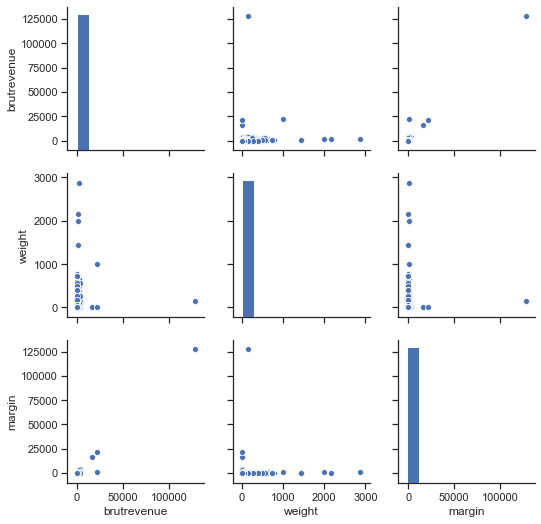

In [50]:
sns.pairplot(df.loc[:, ['brutrevenue', 'weight', 'margin']])

On voit que la représentation du dataset est complètement écrasée par les outliers.

On va clipper ces outliers, sur ces 3 ratios, puis recalculer les ratios initiaux (en particulier, marge en €/kg). 

On calcule d'abord les valeurs limites pour les ratios CA brut, Poids du poste et Marge du poste, en bornant à 3 écarts-types.

In [51]:
def clipvalue(series, stdcount=3):
    return(series.mean() + stdcount * series.std())

ratios = ['brutrevenue', 'weight', 'margin']
clipvals = {ratio : clipvalue(df.loc[:, ratio], stdcount=3) for ratio in ratios}

print(clipvals)

{'brutrevenue': 358.7298072002224, 'weight': 45.29651262183182, 'margin': 294.2004398762829}


On calcule les nouveaux ratios, et on compare aux ratios initiaux.

In [52]:
for ratio, clipval in clipvals.items():
    print(ratio + ' en cours de traitement')
    print(clipval)
    df[ratio + '_clipped'] = df[ratio].clip(lower=-clipval, upper=clipval)

# on recalcule la marge au kg pour avoir de la cohérence
df['marginperkg_clipped'] = df['margin_clipped'] / df['weight_clipped']
    
df=df.copy()
df[['brutrevenue', 'brutrevenue_clipped', 'weight', 'weight_clipped', 'margin', 'margin_clipped', 'marginperkg', 'marginperkg_clipped']].describe()

brutrevenue en cours de traitement
358.7298072002224
weight en cours de traitement
45.29651262183182
margin en cours de traitement
294.2004398762829


,brutrevenue,brutrevenue_clipped,weight,weight_clipped,margin,margin_clipped,marginperkg,marginperkg_clipped
count,1.925004e+06,1.925004e+06,1.925004e+06,1.925004e+06,1.925004e+06,1.925004e+06,1.925004e+06,1.925004e+06
mean,3.484066e+01,3.413987e+01,6.440527e+00,6.020605e+00,9.716434e+00,9.624635e+00,2.453655e+00,2.450359e+00
std,1.079630e+02,4.224050e+01,1.295200e+01,7.604494e+00,9.482800e+01,1.205555e+01,6.661731e+00,2.229902e+00
min,0.000000e+00,0.000000e+00,2.000000e-02,2.000000e-02,-1.072800e+03,-2.942004e+02,-3.174800e+02,-2.942004e+02
25%,1.150000e+01,1.150000e+01,1.650000e+00,1.650000e+00,3.337200e+00,3.337200e+00,1.070000e+00,1.080000e+00
50%,2.070000e+01,2.070000e+01,3.500000e+00,3.500000e+00,6.370000e+00,6.370000e+00,2.020000e+00,2.030000e+00
75%,3.997250e+01,3.997250e+01,6.240000e+00,6.240000e+00,1.185000e+01,1.185000e+01,3.300000e+00,3.300000e+00
max,1.276500e+05,3.587298e+02,2.880000e+03,4.529651e+01,1.275690e+05,2.942004e+02,8.188860e+03,2.942004e+02


Les valeurs moyennes des ratios sont légèrement plus faibles, les écarts types et les valeurs max se sont fortement réduits.

On va à nouveau tenter de représenter la distribution des points.

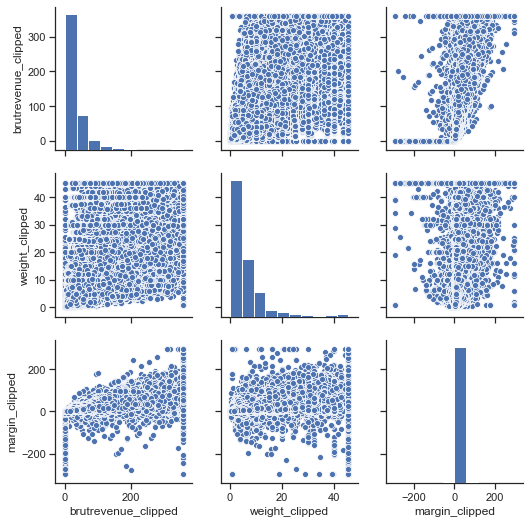

In [53]:
sns.pairplot(df.loc[:, ['brutrevenue_clipped', 'weight_clipped', 'margin_clipped']])

La représentation comporte trop de points pour pouvoir conclure. On analysera un peu plus dans un autre chapitre.

# Calcul du PMVK

On calcule le prix moyen de vente au kilo sur la base des valeurs clippées.

In [54]:
df['pmvk'] = df['brutrevenue_clipped'] / df['weight_clipped']
df['pmvk'].describe()

count    1.925004e+06
mean     7.871721e+00
std      6.110482e+00
min      0.000000e+00
25%      4.100000e+00
50%      6.900000e+00
75%      9.550000e+00
max      3.587298e+02
Name: pmvk, dtype: float64

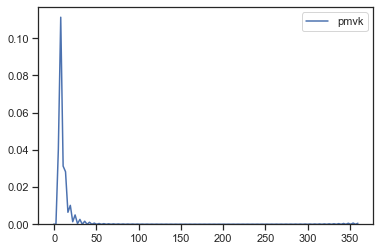

In [55]:
sns.kdeplot(df['pmvk'])

On a à nouveau des outliers sur cette nouvelle donnée, qui "écrasent" la distribution. Si on regarde les pmvk les plus gros : 

In [56]:
df.sort_values('pmvk', ascending=False).head(20)

,date,orgacom,month,week,pricetype,client,doctype,origin,salesgroup,material,brutrevenue,brutrevcur,netrevenue,netrevcur,weight,weightunit,marginperkg,libellé client,code catégorie client,libellé catégorie client,KNA1-KATR5,KNA1-LOEVM,KNVV-LOEVM,KNVV-PLTYP,colonne_source_reco,GrVd,OrgCm,CDis,Groupe,P.,Cde postal,KNA1-KATR1,KNA1-KATR2,KNA1-KATR3,KNA1-KATR4,KNA1-KATR6,flag_reco,libellé article,code gamme,libellé gamme,MARC-MMSTA,MARC-LVORM,MVKE-LVORM,MVKE-MVSTA,MARA-LVORM,Hiérarchie produit,Type d'article,Division,Org. commerciale,Canal distribution,File d'achat,Marque industrielle,Marque commerciale,Grpe de marchandises,Poids net,Unité de p,V1,V2,V3,LG1,LG2,rev_cat,wei_cat,mrg_cat,margin,brutrevenue_clipped,weight_clipped,margin_clipped,marginperkg_clipped,pmvk
921006,2018-07-12,1ALO,201807,201828,ZTG,0000235298,ZC10,#,H14,000000000009800970,495.00,EUR,495.00,EUR,1.000,KG,177.52,CAFE DU MUSEE,ZS,Rest. traditionnelle,ZS,NaN,NaN,T1,NaN,H14,1ALO,10,ZCLT,FR,08600,Z3,Z5,ZK,ZG,ZK,1,Conservateur GT1702 vitre,5,Gamme Régionale,NaN,NaN,NaN,NaN,NaN,801505050505,ZPLV,3E01,1ALO,10,NaN,NaN,NaN,ZAUTRE,39.000,KG,A,A,A,FR,FR,pos,pos,pos,177.52000,358.729807,1.000,177.52000,177.520000,358.729807
1016591,2018-08-22,1ALO,201808,201834,ZTG,0000237251,ZC10,#,928,000000000009800970,495.00,EUR,495.00,EUR,1.000,KG,177.52,REST STUB DES 2 ETANGS,ZS,Rest. traditionnelle,ZS,NaN,NaN,T1,NaN,928,1ALO,10,ZCLT,FR,67190,Z3,Z5,ZK,ZG,ZK,1,Conservateur GT1702 vitre,5,Gamme Régionale,NaN,NaN,NaN,NaN,NaN,801505050505,ZPLV,3E01,1ALO,10,NaN,NaN,NaN,ZAUTRE,39.000,KG,A,A,A,FR,FR,pos,pos,pos,177.52000,358.729807,1.000,177.52000,177.520000,358.729807
82354,2017-08-04,1ALO,201708,201731,ZTG,0000024230,ZC10,#,564,000000000009800085,495.00,EUR,495.00,EUR,1.000,KG,157.20,REST CHALET AU BORD DU LAC,ZS,Rest. traditionnelle,ZS,NaN,NaN,T1,NaN,K00,1ALO,10,ZCLT,FR,88400,Z3,Z5,ZK,ZG,ZK,0,Conservateur GT2402 vitré,5,Gamme Régionale,NaN,NaN,NaN,NaN,NaN,801505050505,ZPLV,3E01,1ALO,10,GLA,NaN,NaN,ZAUTRE,1.000,KG,A,A,A,FR,FR,pos,pos,pos,157.20000,358.729807,1.000,157.20000,157.200000,358.729807
985257,2018-08-08,1ALO,201808,201832,ZTM,0000223889,ZC10,TV,H18,000000000000016694,1075.00,EUR,1075.00,EUR,1.000,KG,1066.27,REST AU CORDON BLEU,ZW,Rest. rapide,ZW,NaN,NaN,T1,NaN,H18,1ALO,10,ZCLT,FR,51170,Z3,Z5,ZK,ZG,ZS,0,Boursin cuisine AFH 19% 1KGx2,4,Gamme Tronc Assortim,NaN,NaN,NaN,NaN,NaN,101015102210,ZNEG,3E01,1ALO,10,FO,21,35,ZFRAIS,1.000,KG,A,A,A,FR,FR,pos,pos,pos,1066.27000,358.729807,1.000,294.20044,294.200440,358.729807
1160005,2018-10-16,1ALO,201810,201842,ZTG,0000165261,ZC10,#,L74,000000000009800970,495.00,EUR,495.00,EUR,1.000,KG,177.52,REST L'ARDENNAIS,ZS,Rest. traditionnelle,ZS,NaN,NaN,T1,NaN,L74,1ALO,10,ZCLT,FR,51100,Z3,Z5,ZK,ZG,ZK,1,Conservateur GT1702 vitre,5,Gamme Régionale,NaN,NaN,NaN,NaN,NaN,801505050505,ZPLV,3E01,1ALO,10,NaN,NaN,NaN,ZAUTRE,39.000,KG,A,A,A,FR,FR,pos,pos,pos,177.52000,358.729807,1.000,177.52000,177.520000,358.729807
1049064,2018-09-04,1ALO,201809,201836,ZTG,0000236749,ZC10,#,562,000000000009800970,495.00,EUR,495.00,EUR,1.000,KG,177.52,REST LE BISTROT DES APOTHICAIRES,ZS,Rest. traditionnelle,ZS,NaN,NaN,T1,NaN,562,1ALO,10,ZCLT,FR,88200,Z3,Z5,ZK,ZG,ZK,0,Conservateur GT1702 vitre,5,Gamme Régionale,NaN,NaN,NaN,NaN,NaN,801505050505,ZPLV,3E01,1ALO,10,NaN,NaN,NaN,ZAUTRE,39.000,KG,A,A,A,FR,FR,pos,pos,pos,177.52000,358.729807,1.000,177.52000,177.520000,358.729807
632373,2018-03-22,1ALO,201803,201812,ZTG,0000024439,ZC10,#,B03,000000000009800970,495.00,EUR,495.00,EUR,1.000,KG,177.52,RESTAURANT FLAMBEE ALSACIENNE,ZU,Rest. à thème,ZU,X,X,T1,NaN,B03,1ALO,10,ZCLT,FR,57100,Z3,Z5,ZK,ZG,ZR,0,Conservateur GT1702 vitre,5,Gamme Régionale,NaN,NaN,NaN,NaN,NaN,801505050505,ZPLV,3E01,1ALO,10,NaN,NaN,NaN,ZAUTRE,39.000,KG,A,A,A,FR,FR,pos,pos,pos,177.52000,358.729807,1.000,177.52000,177.520000,358.729807
840776,2018-06-13,1ALO,201806,201824,ZTG,0000233640,ZC10,#,601,000000000009800970,495.00,EUR,495.00,EUR,1.000,KG,177.52,REST AU FOURNIL DE FRED,ZS,Rest. traditionnelle,ZS,NaN,NaN,T2,NaN,601

Au-delà de quelques erreurs de prix, on voit que l'article 9800085 Conservateur GT1702 vitre est sur représenté. Il s'agit d'un article de PLV (une sorte de frigo), qui coûte 495€ pour lequel le poids de la ligne remonte à 1kg (d'où un pmvk décalé). Il s'agissait d'une erreur sur le poids de l'article, qui a été ensuite corrigée.

On va à nouveau clipper cette donnée, sachant qu'il y aura une incohérence sur les lignes corrigées entre PMVK, CA brut et poids (on ne souhaite pas modifier CA brut ou poids).

In [57]:
pmvk_clip = clipvalue(df.loc[:, 'pmvk'], stdcount=3)
pmvk_clip

26.203166612848594

In [58]:
df['pmvk_clipped'] = df['pmvk'].clip(lower=-pmvk_clip, upper=pmvk_clip)
df[['pmvk', 'pmvk_clipped']].describe()

,pmvk,pmvk_clipped
count,1.925004e+06,1.925004e+06
mean,7.871721e+00,7.708324e+00
std,6.110482e+00,5.292891e+00
min,0.000000e+00,0.000000e+00
25%,4.100000e+00,4.100000e+00
50%,6.900000e+00,6.900000e+00
75%,9.550000e+00,9.550000e+00
max,3.587298e+02,2.620317e+01


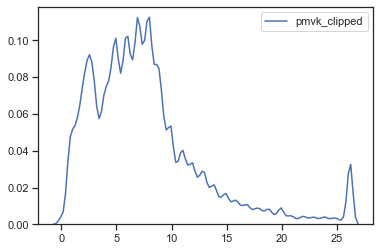

In [59]:
sns.kdeplot(df['pmvk_clipped'])

Au-delà de l'artefact de droite dû au "clippage", on a une courbe plutôt irrégulière...

# Analyse détaillée des ratios entre eux

On passe sur une visualisation de la densité du noyau pour mieux voir la répartition des points sur le dataset.

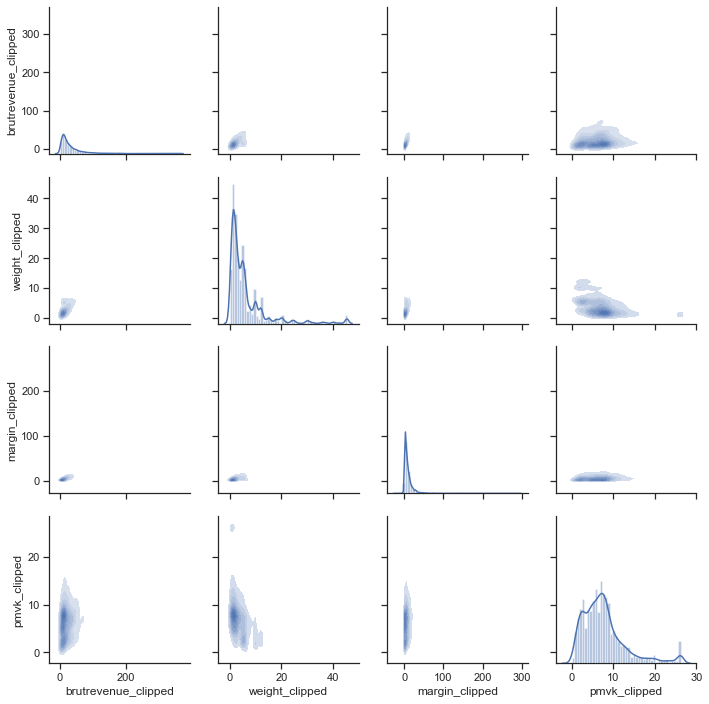

In [60]:
g = sns.PairGrid(df.loc[:, ['brutrevenue_clipped', 'weight_clipped', 'margin_clipped', 'pmvk_clipped']].sample(5000))
g = g.map_offdiag(sns.kdeplot, shade=True, shade_lowest=False)
g = g.map_diag(sns.distplot)

On voit que même après avoir réduit les extremums, les points sont concentrés dans un tout petit espace. De plus, la répartition des poids des postes montre des irrégularités curieuses.

Si on zoome sur les zones représentatives, on obtient la visualisation suivante :

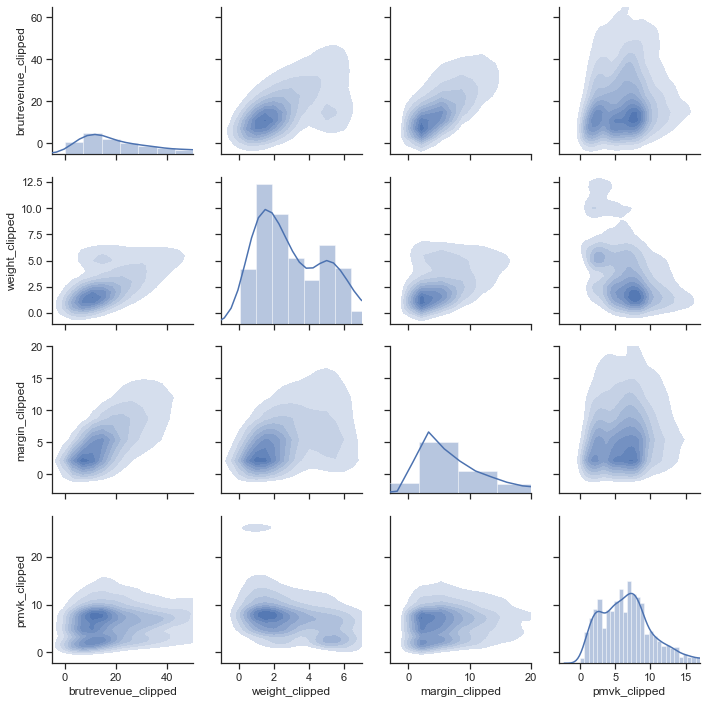

In [61]:
g.axes[0,1].set_ylim(-5, 65)
g.axes[0,2].set_xlim(-3, 20)
g.axes[1,0].set_ylim(-1, 13)
g.axes[1,0].set_xlim(-5, 50)
g.axes[2,1].set_ylim(-3, 20)
g.axes[2,1].set_xlim(-1, 7)
g.axes[0,3].set_xlim(-3, 17)
g.fig

Globalement, on voit bien que les données sur les 3 premiers ratios semblent linéairement corrélées (les tâches sont plutôt le long d'une droite y = ax). Néanmoins, il y a une "verrue", qu'on voit par exemple aux alentours de weight = 5 et brutrevenue = 15.

Les irrégularités sur la courbe du poids (le graphe central, sur lequel on voit un second maximum local) sont sur des lignes qui doivent avoir un PMVK qui est plus faible (poids plus important, mais CA à peu près similaire).

In [62]:
hue_var = 'Grpe de marchandises'
sample_size = 5000

df_plot = df.loc[:, ['brutrevenue_clipped', 'weight_clipped', 'margin_clipped', 'pmvk_clipped', hue_var]].sample(sample_size)
print(df_plot.groupby(hue_var).count())
print(df_plot[hue_var].cat.categories)
df_plot[hue_var].cat.remove_unused_categories(inplace=True)
print(df_plot[hue_var].cat.categories)
df_plot.head()

                      brutrevenue_clipped  weight_clipped  margin_clipped  \
Grpe de marchandises                                                        
ZAUTRE                                  0               0               0   
ZEPI                                    0               0               0   
ZFRAIS                               3212            3212            3212   
ZSURGE                               1788            1788            1788   

                      pmvk_clipped  
Grpe de marchandises                
ZAUTRE                           0  
ZEPI                             0  
ZFRAIS                        3212  
ZSURGE                        1788  
Index(['ZAUTRE', 'ZEPI', 'ZFRAIS', 'ZSURGE'], dtype='object')
Index(['ZFRAIS', 'ZSURGE'], dtype='object')


,brutrevenue_clipped,weight_clipped,margin_clipped,pmvk_clipped,Grpe de marchandises
1841359,8.75,5.000000,5.1000,1.750000,ZSURGE
1504025,76.00,45.296513,16.0000,1.677833,ZSURGE
236788,32.81,1.000000,2.4500,26.203167,ZSURGE
279562,40.00,5.000000,9.4000,8.000000,ZSURGE
1264959,51.20,3.440000,24.9056,14.883721,ZSURGE


In [63]:
#g2 = sns.PairGrid(df_plot, hue=hue_var)
#g2 = g2.map_offdiag(sns.kdeplot,shade=True, shade_lowest=False, alpha=0.5)
#g2 = g2.map_diag(sns.kdeplot)


In [64]:
#g2.axes[0,1].set_ylim(-5, 65)
#g2.axes[0,2].set_xlim(-3, 20)
#g2.axes[1,0].set_ylim(-1, 13)
#g2.axes[1,0].set_xlim(-5, 50)
#g2.axes[2,1].set_ylim(-3, 20)
#g2.axes[2,1].set_xlim(-1, 7)
#g2.axes[0,3].set_xlim(-3, 17)
#g2 = g2.add_legend()
#g2.fig

# Analyse par jour de la semaine

In [65]:
df['weekday'] = df['date'].dt.weekday + 1
df.tail()

,date,orgacom,month,week,pricetype,client,doctype,origin,salesgroup,material,brutrevenue,brutrevcur,netrevenue,netrevcur,weight,weightunit,marginperkg,libellé client,code catégorie client,libellé catégorie client,KNA1-KATR5,KNA1-LOEVM,KNVV-LOEVM,KNVV-PLTYP,colonne_source_reco,GrVd,OrgCm,CDis,Groupe,P.,Cde postal,KNA1-KATR1,KNA1-KATR2,KNA1-KATR3,KNA1-KATR4,KNA1-KATR6,flag_reco,libellé article,code gamme,libellé gamme,MARC-MMSTA,MARC-LVORM,MVKE-LVORM,MVKE-MVSTA,MARA-LVORM,Hiérarchie produit,Type d'article,Division,Org. commerciale,Canal distribution,File d'achat,Marque industrielle,Marque commerciale,Grpe de marchandises,Poids net,Unité de p,V1,V2,V3,LG1,LG2,rev_cat,wei_cat,mrg_cat,margin,brutrevenue_clipped,weight_clipped,margin_clipped,marginperkg_clipped,pmvk,pmvk_clipped,weekday
2119808,2019-10-23,1ALO,201910,201943,ZTP,0000266037,ZC10,VR,928,000000000000189490,34.95,EUR,34.95,EUR,5.00,KG,1.41,LA TAVERNA DI POMPEI,ZS,Rest. traditionnelle,ZS,NaN,NaN,T1,NaN,928,1ALO,10,ZCLT,FR,67204,Z3,Z5,ZK,ZG,ZK,0,PF merlu blanc s/p s/a (110G/5KG) 8B,4,Gamme Tronc Assortim,NaN,NaN,NaN,NaN,NaN,501015055005,ZNEG,3E01,1ALO,10,POI,11,213,ZSURGE,5.0,KG,A,A,A,FR,FR,pos,pos,pos,7.0500,34.95,5.00,7.0500,1.41,6.990000,6.990000,3
2119809,2019-10-23,1ALO,201910,201943,ZTP,0000266361,ZC10,VR,625,000000000000100445,18.00,EUR,18.00,EUR,1.80,KG,3.94,RESTAURANT DE LA GARE,ZS,Rest. traditionnelle,ZS,NaN,NaN,T1,NaN,625,1ALO,10,ZCLT,FR,67590,Z3,Z5,ZK,ZG,ZK,0,Moelleux au chocolat (100Gx18),4,Gamme Tronc Assortim,NaN,NaN,NaN,NaN,NaN,201520150505,ZNEG,3E01,1ALO,10,ESU,454,999,ZSURGE,1.8,KG,A,A,A,FR,FR,pos,pos,pos,7.0920,18.00,1.80,7.0920,3.94,10.000000,10.000000,3
2119811,2019-10-23,1ALO,201910,201943,ZTP,0000267099,ZC10,VR,I85,000000000000097453,12.96,EUR,12.96,EUR,0.87,KG,3.26,BAR AMERICAIN LES RAOUDIS,ZS,Rest. traditionnelle,ZS,NaN,NaN,T1,NaN,I85,1ALO,10,ZCLT,FR,57000,Z3,Z5,ZK,ZG,ZK,0,Tomme ail ours 28% 400Gx13 P.Antoine,5,Gamme Régionale,NaN,NaN,NaN,NaN,NaN,101015054095,ZNEG,3E01,1ALO,10,FO,J44,999,ZFRAIS,1.0,KG,A,A,A,FR,FR,pos,pos,pos,2.8362,12.96,0.87,2.8362,3.26,14.896552,14.896552,3
2119812,2019-10-23,1ALO,201910,201943,ZTP,0000267099,ZC10,VR,I85,000000000000097454,7.40,EUR,7.40,EUR,0.40,KG,4.88,BAR AMERICAIN LES RAOUDIS,ZS,Rest. traditionnelle,ZS,NaN,NaN,T1,NaN,I85,1ALO,10,ZCLT,FR,57000,Z3,Z5,ZK,ZG,ZK,0,Carre aff mirabel 18% 200Gx12 Pere Antoi,5,Gamme Régionale,NaN,NaN,NaN,NaN,NaN,101015052520,ZNEG,3E01,1ALO,10,FO,999,999,ZFRAIS,0.2,KG,A,A,A,FR,FR,pos,pos,pos,1.9520,7.40,0.40,1.9520,4.88,18.500000,18.500000,3
2119813,2019-10-23,1ALO,201910,201943,ZTP,0000267099,ZC10,VR,I85,000000000000099476,16.73,EUR,16.73,EUR,1.40,KG,2.06,BAR AMERICAIN LES RAOUDIS,ZS,Rest. traditionnelle,ZS,NaN,NaN,T1,NaN,I85,1ALO,10,ZCLT,FR,57000,Z3,Z5,ZK,ZG,ZK,0,Entrecote veau UE 1KGx16,5,Gamme Régionale,NaN,NaN,NaN,NaN,NaN,401040251045,ZNEG,3E01,1ALO,10,VIA,999,999,ZFRAIS,1.0,KG,A,A,A,FR,FR,pos,pos,pos,2.8840,16.73,1.40,2.8840,2.06,11.950000,11.950000,3


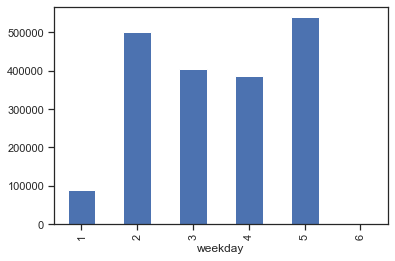

In [66]:
#print(df.groupby('weekday')['client'].count())
ax = df.groupby('weekday')['client'].count().plot(kind='bar')

Pour éviter d'avoir des effets de bord lors de l'affichage temporel, on droppe les lignes qui concernent des samedis.

In [67]:
df.groupby('weekday').size()

weekday
1     89801
2    502542
3    405352
4    386764
5    540539
6         6
dtype: int64

In [68]:
df = df[df['weekday'] != 6].copy()

In [69]:
df.groupby('weekday').size()

weekday
1     89801
2    502542
3    405352
4    386764
5    540539
dtype: int64

On calcule le nombre de postes par jour et le nombre de commandes par jour. On peut d'abord définir une liste d'axes complémentaires pour l'analyse, en listant les critères dans la liste suivantes.

In [70]:
crit_list = ['flag_reco']

In [71]:
df_postes = df.groupby(['date'] + crit_list).size()
df_postes.head()

date        flag_reco
2017-07-03  0             471
            1             250
2017-07-04  0            2725
            1            1937
2017-07-05  0            2275
dtype: int64

In [72]:
df_commandes = df.groupby(['date', 'client'] + crit_list).size().groupby(['date'] + crit_list).size()
df_commandes.head()

date        flag_reco
2017-07-03  0             51
            1             29
2017-07-04  0            268
            1            166
2017-07-05  0            243
dtype: int64

In [73]:
df_commandes = pd.concat([df_commandes, df_postes], axis=1)
df_commandes.head()

0     1
date       flag_reco           
2017-07-03 0           51   471
           1           29   250
2017-07-04 0          268  2725
           1          166  1937
2017-07-05 0          243  2275

In [74]:
df_commandes.columns = ['commandes', 'postes']

In [75]:
df_commandes['nb_moy_lig'] = df_commandes['postes'] / df_commandes['commandes']
df_commandes.reset_index(inplace=True)
df_commandes.head()

,date,flag_reco,commandes,postes,nb_moy_lig
0,2017-07-03,0,51,471,9.235294
1,2017-07-03,1,29,250,8.620690
2,2017-07-04,0,268,2725,10.167910
3,2017-07-04,1,166,1937,11.668675
4,2017-07-05,0,243,2275,9.362140


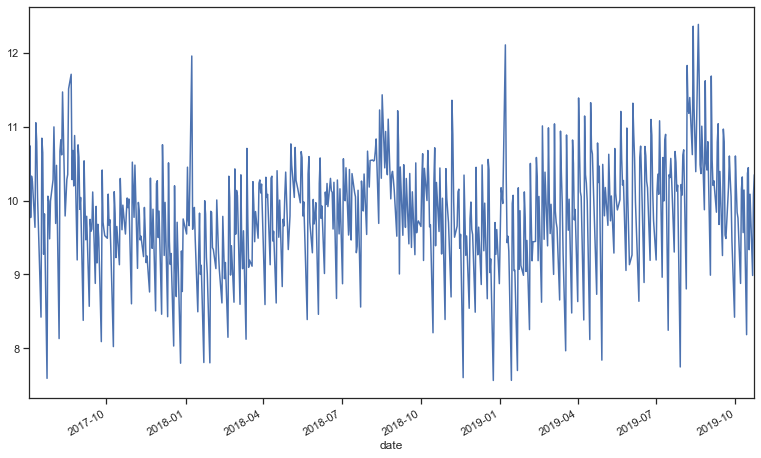

In [76]:
df_agg = df_commandes[['commandes', 'postes', 'date']].groupby('date').sum()
df_agg['nb_moy_lig'] = df_agg['postes'] / df_agg['commandes']
ax = df_agg['nb_moy_lig'].plot(kind='line', figsize=(13, 8))


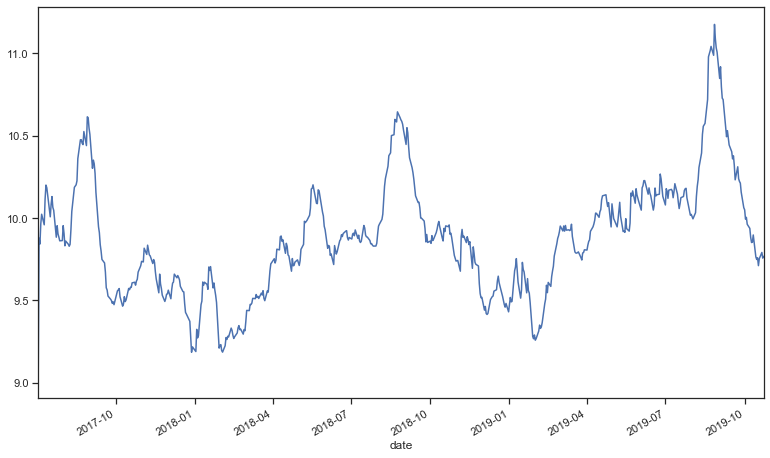

In [77]:
ax = df_agg.rolling(window=15, min_periods=0).mean()['nb_moy_lig'].plot(kind='line', figsize = (13, 8))

Il semblerait qu'il y ait une saisonnalité au niveau de cet indicateur. On affiche en empilant les données année par année pour se faire une idée.

In [78]:
df_agg.reset_index(inplace=True)
df_agg['year'] = df_agg['date'].apply(lambda x: x.year)
df_agg['dayofyear'] = df_agg['date'].apply(lambda x: x.dayofyear)
df_agg.head()

,date,commandes,postes,nb_moy_lig,year,dayofyear
0,2017-07-03,80,721,9.012500,2017,184
1,2017-07-04,434,4662,10.741935,2017,185
2,2017-07-05,377,3683,9.769231,2017,186
3,2017-07-06,351,3626,10.330484,2017,187
4,2017-07-07,484,4965,10.258264,2017,188


Text(0.5, 1.0, 'Nombre de lignes par commande - Comparatif entre années')

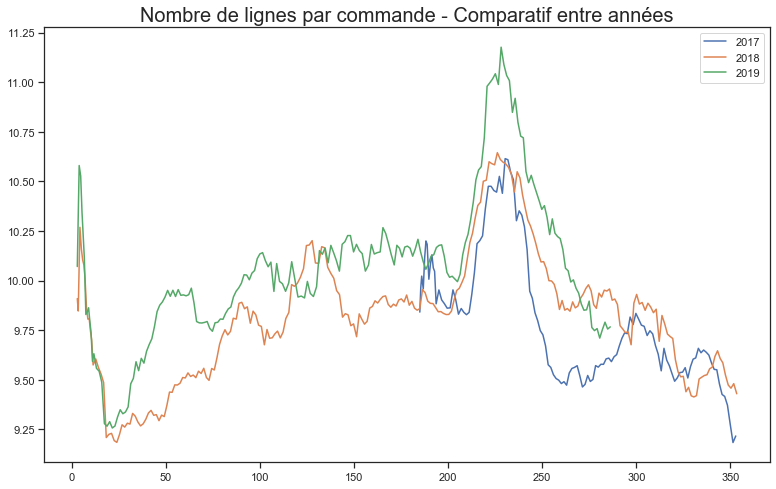

In [79]:
fig, ax = plt.subplots(figsize=(13,8))
for year_ in [2017, 2018, 2019]:
    df_plot = df_agg.loc[df_agg['year'] == year_].reset_index(drop=True).rolling(window=15, min_periods=3).mean()
    line, = ax.plot(df_plot['dayofyear'], df_plot['nb_moy_lig'])
    line.set_label(str(year_))
ax.legend()
ax.set_title("Nombre de lignes par commande - Comparatif entre années", fontsize=20)

Text(0.5, 1.0, 'Nombre de lignes par commande - Comparatif A/B test')

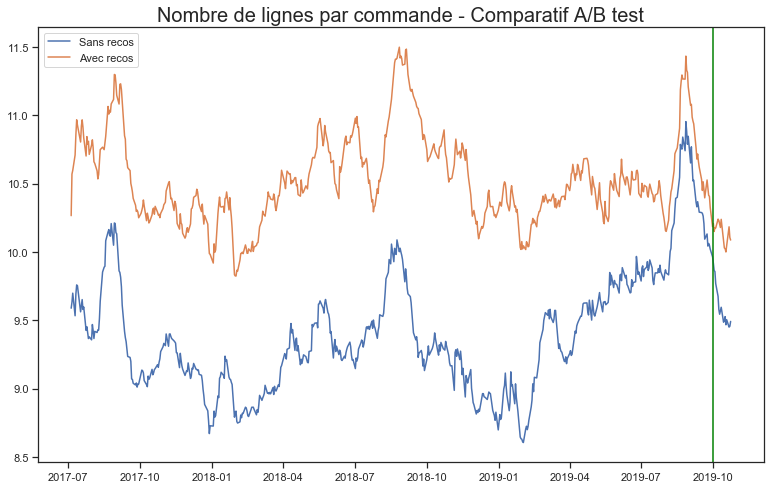

In [80]:
fig, ax = plt.subplots(figsize=(13, 8))
labels = ['Sans recos', 'Avec recos']
for i in range(2):
    df2 = df_commandes.loc[df_commandes.flag_reco == i].set_index('date').rolling(window=15, min_periods=3).mean().reset_index()
    line, = ax.plot(df2['date'].dt.to_pydatetime(), df2['nb_moy_lig'])
    line.set_label(labels[i])
ax.legend()
ax.axvline(x=pd.to_datetime('20190930'), color='green')
#ax.set_xlim(pd.to_datetime('20181101'))
ax.set_title("Nombre de lignes par commande - Comparatif A/B test", fontsize=20)

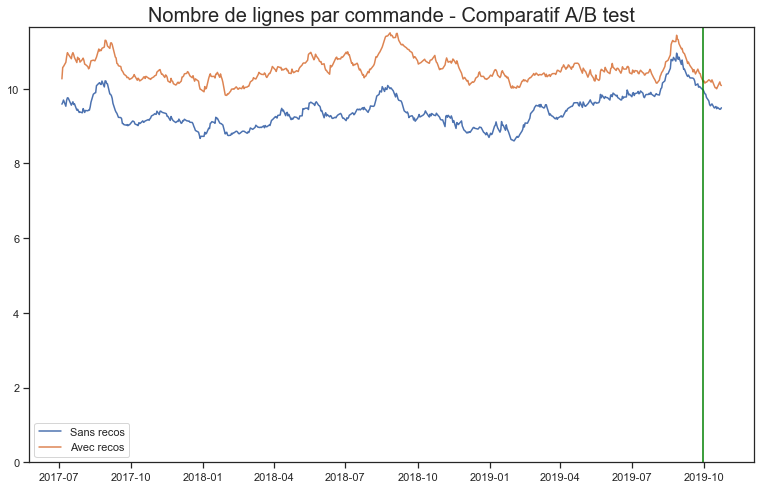

In [81]:
ax.set_ylim(0)
ax.figure

# Analyse des recos "trop similaires"

On va identifier les recommandations "trop similaires" à des produits déjà récurrents.

On commence par calculer les produits récurrents par client.

In [82]:
df['rank_commandes_par_resto'] = df.groupby('client')['date'].rank('dense', ascending=False)
ds3 = df.loc[df['rank_commandes_par_resto']<=12].groupby(['client', 'material']).size()
ds3 = ds3.rename('order_count_last_12')
ds3

client      material          
0000020667  000000000000004813    10
            000000000000007235     1
            000000000000007417     8
            000000000000008749     1
            000000000000009249     1
                                  ..
0000267099  000000000000147055     1
            000000000000155070     1
            000000000000159742     1
            000000000000176177     1
            000000000000191301     1
Name: order_count_last_12, Length: 94236, dtype: int64

In [83]:
df = df.merge(ds3.reset_index(), how='left', on=['client', 'material'], validate='m:1')
df['order_count_last_12'].fillna(0, inplace=True)
df.head()

,date,orgacom,month,week,pricetype,client,doctype,origin,salesgroup,material,brutrevenue,brutrevcur,netrevenue,netrevcur,weight,weightunit,marginperkg,libellé client,code catégorie client,libellé catégorie client,KNA1-KATR5,KNA1-LOEVM,KNVV-LOEVM,KNVV-PLTYP,colonne_source_reco,GrVd,OrgCm,CDis,Groupe,P.,Cde postal,KNA1-KATR1,KNA1-KATR2,KNA1-KATR3,KNA1-KATR4,KNA1-KATR6,flag_reco,libellé article,code gamme,libellé gamme,MARC-MMSTA,MARC-LVORM,MVKE-LVORM,MVKE-MVSTA,MARA-LVORM,Hiérarchie produit,Type d'article,Division,Org. commerciale,Canal distribution,File d'achat,Marque industrielle,Marque commerciale,Grpe de marchandises,Poids net,Unité de p,V1,V2,V3,LG1,LG2,rev_cat,wei_cat,mrg_cat,margin,brutrevenue_clipped,weight_clipped,margin_clipped,marginperkg_clipped,pmvk,pmvk_clipped,weekday,rank_commandes_par_resto,order_count_last_12
0,2017-07-03,1ALO,201707,201727,ZTCE,0000022129,ZC10,VR,H19,000000000000002477,12.70,EUR,12.19,EUR,24.768,KG,0.07,COMPTOIR DE LA LICORNE CHALONS,ZS,Rest. traditionnelle,ZS,NaN,NaN,T1,NaN,H19,1ALO,10,ZCLT,FR,51000,Z3,Z5,ZK,ZG,ZK,0,Lait 1/2 ecreme UHT France (1Lx6brq),4,Gamme Tronc Assortim,NaN,NaN,NaN,NaN,NaN,101020151010,ZNEG,3E01,1ALO,10,UF,999,999,ZFRAIS,1.032,KG,A,A,A,FR,FR,pos,pos,pos,1.73376,12.70,24.768,1.73376,0.07,0.512758,0.512758,1,160.0,6.0
1,2017-07-03,1ALO,201707,201727,ZTCE,0000022129,ZC10,VR,H19,000000000000008231,16.46,EUR,15.80,EUR,4.000,KG,0.49,COMPTOIR DE LA LICORNE CHALONS,ZS,Rest. traditionnelle,ZS,NaN,NaN,T1,NaN,H19,1ALO,10,ZCLT,FR,51000,Z3,Z5,ZK,ZG,ZK,0,Emmental rape 29% 1KGx10 PPF,4,Gamme Tronc Assortim,NaN,NaN,NaN,NaN,NaN,101015102015,ZNEG,3E01,1ALO,10,FO,11,4,ZFRAIS,1.000,KG,A,A,A,FR,FR,pos,pos,pos,1.96000,16.46,4.000,1.96000,0.49,4.115000,4.115000,1,160.0,2.0
2,2017-07-03,1ALO,201707,201727,ZTCE,0000022130,ZC10,TV,J88,000000000000034922,120.39,EUR,115.57,EUR,3.000,KG,3.71,COMPTOIR DE MAITRE KANTER BAR LE DU,ZS,Rest. traditionnelle,ZS,NaN,NaN,T1,NaN,J88,1ALO,10,ZCLT,FR,55000,Z3,Z5,ZK,ZG,ZK,0,FG canard cru eveine plaque 500Gx6,4,Gamme Tronc Assortim,NaN,NaN,NaN,NaN,NaN,401530150505,ZNEG,3E01,1ALO,10,VOL,124,17,ZSURGE,0.500,KG,A,A,A,FR,FR,pos,pos,pos,11.13000,120.39,3.000,11.13000,3.71,40.130000,26.203167,1,212.0,1.0
3,2017-07-03,1ALO,201707,201727,ZTCE,0000022130,ZC10,TV,J88,000000000000004578,97.02,EUR,93.14,EUR,10.000,KG,1.42,COMPTOIR DE MAITRE KANTER BAR LE DU,ZS,Rest. traditionnelle,ZS,NaN,NaN,T1,NaN,J88,1ALO,10,ZCLT,FR,55000,Z3,Z5,ZK,ZG,ZK,0,Crevette ent cru sauv 10/20Pce/KG 2KGx6,4,Gamme Tronc Assortim,NaN,NaN,NaN,NaN,NaN,500505100510,ZNEG,3E01,1ALO,10,CRUST MOL,999,999,ZSURGE,2.000,KG,A,A,A,FR,FR,pos,pos,pos,14.20000,97.02,10.000,14.20000,1.42,9.702000,9.702000,1,212.0,0.0
4,2017-07-03,1ALO,201707,201727,ZTCN,0000093753,ZC10,VR,I85,000000000000013148,12.82,EUR,11.92,EUR,6.000,KG,0.32,HOTEL MODERNE CAHEN ET CIE,ZT,Rest. hôtelière,ZT,NaN,NaN,T1,NaN,I85,1ALO,10,ZCLT,FR,57000,Z3,Z5,ZK,ZG,ZM,0,Yt Danone et Fruit panaché (125Gx8)x6,6,Gamme Imposée Grands,NaN,NaN,NaN,NaN,NaN,101025351010,ZNEG,3E01,1ALO,10,UF,28,62,ZFRAIS,1.000,KG,A,A,A,FR,FR,pos,pos,pos,1.92000,12.82,6.000,1.92000,0.32,2.136667,2.136667,1,42.0,12.0


In [84]:
# A Voir, à priori inutile
#df2 = df[df.groupby(['client', 'Hiérarchie produit'], observed=True)['order_count_last_12'].transform('max').eq(df['order_count_last_12'])]
#df2[df2['order_count_last_12']>=3].tail()

#df2 = df[df['order_count_last_12'] >= 3]
#df3 = df_prev_reco.merge(df2, 
#                         how='inner',
#                         left_on=['Code_client', 'Hiérarchie produit'],
#                         right_on=['client', 'Hiérarchie produit'])

#df3.head()

On construit une série qui permet de garder le nombre d'articles présents dans l'historique de chaque noeud de hiérarchie.

In [85]:
myIndex = pd.Index([''])
uniq = df['material'].nunique()
ds = pd.Series(data=[uniq], index=myIndex)
for myLen in range(1,7):
    df['H'+str(myLen)] = df['Hiérarchie produit'].apply(lambda x: x[:(myLen*2)])
    ds = pd.concat([ds, df.groupby(['material', 'H' + str(myLen)]).size().groupby('H' + str(myLen)).size()])
ds.sort_index(inplace=True)
ds.head(25)

                4599
10              1125
1005              65
100505             5
10050505           5
1005050520         3
100505052005       3
1005050525         2
100505052505       2
100510            59
10051005          42
1005100505         4
100510050505       4
1005100510         1
100510051005       1
1005100515         8
100510051505       8
1005100520         3
100510052005       3
1005100525         1
100510052505       1
1005100530        22
100510053005      22
1005100540         3
100510054005       3
dtype: int64

On écrit une fonction qui retourne la distance entre 2 articles.

In [86]:
def mat_dist(mat1, mat2):
    if mat1 == mat2:
        return(0)
    else:
        myLen = 0
        h1, h2 = df[df['material'] == mat1].iloc[0]['H6'], df[df['material'] == mat2].iloc[0]['H6']
        while(h1[:(myLen*2)] == h2[:(myLen*2)]) and myLen < 6:
            myLen += 1
        return(ds[h1[:((myLen-1)*2)]])    


In [87]:
mat_dist('000000000000000433','000000000000000433')

0

In [88]:
import datetime
print(datetime.datetime.now())

2019-11-19 15:46:05.773663
